In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import visual_behavior_glm
import visual_behavior_glm.GLM_params as glm_params
import visual_behavior_glm.GLM_analysis_tools as gat

import visual_behavior.data_access.loading as loading
import visual_behavior.data_access.utilities as utilities
import visual_behavior.visualization.utils as utils

In [2]:
import seaborn as sns

sns.set_context('notebook', font_scale=1.5, rc={'lines.markeredgewidth': 2})
sns.set_style('white', {'axes.spines.right': False, 'axes.spines.top': False, 'xtick.bottom': True, 'ytick.left': True, })
sns.set_palette('deep')

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

### get experiments_table

In [4]:
experiments_table = loading.get_platform_paper_experiment_table()
cells_table = loading.get_cell_table()

## get results for glm version 15 with events

In [5]:
model_output_type = 'adj_fraction_change_from_full'
glm_version = '15_events_L2_optimize_by_session'

rspm = gat.build_pivoted_results_summary(value_to_use=model_output_type, results_summary=None, 
                                       glm_version=glm_version, cutoff=None, add_extra_columns=True)
original_rspm = rspm.copy()

In [6]:
model_output_type = 'adj_fraction_change_from_full'
glm_version = '15_events_L2_optimize_by_session'

filtered_rspm = gat.build_pivoted_results_summary(value_to_use=model_output_type, results_summary=None, 
                                       glm_version=glm_version, cutoff=0.01, add_extra_columns=True)

original_filtered_rspm = filtered_rspm.copy()

In [7]:
len(rspm)

66156

In [8]:
len(filtered_rspm)

24227

### limit to passive sessions

In [9]:
rspm = rspm[rspm.passive==False]

In [10]:
len(rspm)

45900

In [11]:
# Ai94 data is not in here, thats good
rspm.full_genotype.unique()

array(['Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt',
       'Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt',
       'Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-GCaMP6f)/wt'],
      dtype=object)

In [12]:
rspm.head()

identifier  Full  all-images  beh_model  behavioral  cognitive  \
0  1000743008_1086668144   0.0   -0.683742        0.0   -0.057898  -0.045154   
1  1000743008_1086668169   0.0   -0.741935        0.0    0.000000  -0.017139   
2  1000743008_1086668188   0.0   -0.636783        0.0   -0.015286  -0.045929   
3  1000743008_1086668228   0.0   -0.733936        0.0   -0.034683  -0.015350   
4  1000743008_1086668247   0.0    0.000000        0.0    0.000000   0.000000   

   correct_rejects  expectation  false_alarms      hits  ...  area_depth  \
0         -0.05488    -0.125303      0.000000 -0.132245  ...    VISp_275   
1          0.00000     0.000000      0.000000 -0.054902  ...    VISp_275   
2          0.00000    -0.023563      0.000000 -0.133889  ...    VISp_275   
3          0.00000    -0.161129     -0.005041 -0.064744  ...    VISp_275   
4          0.00000     0.000000      0.000000  0.000000  ...    VISp_275   

   area_binned_depth        date  first_novel  n_relative_to_first_novel  \
0           VISp_275  20200116.0        False                        NaN   
1           VISp_275  20200116.0        False                        NaN   
2           VISp_275  20200116.0        False                        NaN   
3           VISp_275  20200116.0        False                        NaN   
4           VISp_275  20200116.0        False                        NaN   

   last_familiar  last_familiar_active  second_novel  second_novel_active  \
0          False                 False         False                False   
1          False                 False         False                False   
2          False                 False         False                False   
3          False                 False         False                False   
4          False                 False         False                False   

   experience_exposure  
0           Familiar 1  
1           Familiar 1  
2           Familiar 1  
3           Familiar 1  
4           Familiar 1  

[5 rows x 111 columns]

#### select regressors to evaluate

In [13]:
def get_default_features(single=False):
    features = [
     'all-images',
     'omissions',
     'licks',
     'pupil',
     'running',
#      'face_motion_energy', # ignore due to issues with QC
     'hits',
     'misses',
     'false_alarms',
     'correct_rejects',
#      'passive_change', 
#      'beh_model'
     ]
    if single:
        features = ['single-'+feature for feature in features]
    return features

In [14]:
features_to_plot = get_default_features(single=False)

In [15]:
level_up_features = [
'all-images',
'omissions',
'behavioral',
'task',
 ]

In [16]:
features_to_plot = level_up_features

#### get useful things

In [17]:
df = rspm.copy()
cell_types = np.sort(df.cell_type.unique())[::-1]
experience_levels = np.sort(df.experience_level.unique())

### get experiments & cells of interest

Limit to multiscope, most recent active sessions

In [18]:
expts = experiments_table.copy()
expts = expts[expts.passive==False]
# expts = expts[expts.project_code=='VisualBehaviorMultiscope']
# expts = utilities.limit_to_last_familiar_second_novel_active(expts)
expts = utilities.limit_to_containers_with_all_experience_levels(expts)

Check distribution of exposure number for this set of experiments 

In [19]:
expts.groupby(['cell_type', 'experience_level', 'prior_exposures_to_image_set']).mean().reset_index().groupby(['cell_type', 'experience_level']).describe()[['prior_exposures_to_image_set']]

prior_exposures_to_image_set             \
                                                       count       mean   
cell_type      experience_level                                           
Excitatory     Familiar                                 36.0  28.305556   
               Novel 1                                   1.0   0.000000   
               Novel >1                                  6.0   3.500000   
Sst Inhibitory Familiar                                 29.0  33.000000   
               Novel 1                                   1.0   0.000000   
               Novel >1                                  5.0   3.000000   
Vip Inhibitory Familiar                                 26.0  29.692308   
               Novel 1                                   1.0   0.000000   
               Novel >1                                  7.0   4.000000   

                                                                            
                                       std   min    25%   50%    75%   max  
cell_type      experience_level                                             
Excitatory     Familiar          14.552014   8.0  16.75  26.5  36.25  59.0  
               Novel 1                 NaN   0.0   0.00   0.0   0.00   0.0  
               Novel >1           1.870829   1.0   2.25   3.5   4.75   6.0  
Sst Inhibitory Familiar          17.928429   9.0  19.00  29.0  43.00  69.0  
               Novel 1                 NaN   0.0   0.00   0.0   0.00   0.0  
               Novel >1           1.581139   1.0   2.00   3.0   4.00   5.0  
Vip Inhibitory Familiar          14.979370  10.0  17.25  24.5  45.50  53.0  
               Novel 1                 NaN   0.0   0.00   0.0   0.00   0.0  
               Novel >1           2.160247   1.0   2.50   4.0   5.50   7.0

Get cells for those experiments

In [20]:
cells = cells_table.copy()
# limit cells table to experiments in most recent active sessions
cells = cells[cells.ophys_experiment_id.isin(expts.index.values)]
utilities.count_mice_expts_containers_cells(cells)

n_mouse_id  n_ophys_experiment_id  \
cell_type      experience_level                                      
Excitatory     Familiar                  35                    147   
               Novel 1                   35                     65   
               Novel >1                  35                     79   
Sst Inhibitory Familiar                  15                     81   
               Novel 1                   15                     34   
               Novel >1                  15                     51   
Vip Inhibitory Familiar                  17                     95   
               Novel 1                   17                     42   
               Novel >1                  17                     62   

                                 n_ophys_container_id  n_cell_specimen_id  
cell_type      experience_level                                            
Excitatory     Familiar                            65               11822  
               Novel 1                             65                8291  
               Novel >1                            65                8275  
Sst Inhibitory Familiar                            34                 500  
               Novel 1                             34                 371  
               Novel >1                            34                 388  
Vip Inhibitory Familiar                            42                1075  
               Novel 1                             42                 718  
               Novel >1                            42                 857

Limit to matched cells and count

In [21]:
# now identify cells matched in all 3 experience levels
cells = utilities.limit_to_cell_specimen_ids_matched_in_all_experience_levels(cells)
# count
utilities.count_mice_expts_containers_cells(cells)

n_mouse_id  n_ophys_experiment_id  \
cell_type      experience_level                                      
Excitatory     Familiar                  35                    146   
               Novel 1                   35                     65   
               Novel >1                  35                     79   
Sst Inhibitory Familiar                  14                     79   
               Novel 1                   14                     32   
               Novel >1                  14                     49   
Vip Inhibitory Familiar                  17                     94   
               Novel 1                   17                     42   
               Novel >1                  17                     62   

                                 n_ophys_container_id  n_cell_specimen_id  
cell_type      experience_level                                            
Excitatory     Familiar                            65                4294  
               Novel 1                             65                4294  
               Novel >1                            65                4294  
Sst Inhibitory Familiar                            32                 241  
               Novel 1                             32                 241  
               Novel >1                            32                 241  
Vip Inhibitory Familiar                            42                 466  
               Novel 1                             42                 466  
               Novel >1                            42                 466

### limit rspm to matched cells, most recent familiar and novel >1 active

In [22]:
len(rspm.cell_specimen_id.unique())

20660

In [23]:
rspm = rspm[rspm.ophys_experiment_id.isin(expts.index.values)]
len(rspm.cell_specimen_id.unique())

15473

In [24]:
rspm = rspm[rspm.cell_specimen_id.isin(cells.cell_specimen_id.values)]
len(rspm.cell_specimen_id.unique())

4334

In [25]:
utilities.count_mice_expts_containers_cells(rspm)

n_mouse_id  n_ophys_experiment_id  \
cell_type      experience_level                                      
Excitatory     Familiar                  31                    129   
               Novel 1                   31                     56   
               Novel >1                  31                     64   
Sst Inhibitory Familiar                  11                     62   
               Novel 1                   11                     24   
               Novel >1                  11                     36   
Vip Inhibitory Familiar                  17                     94   
               Novel 1                   17                     42   
               Novel >1                  17                     62   

                                 n_ophys_container_id  n_cell_specimen_id  
cell_type      experience_level                                            
Excitatory     Familiar                            56                3672  
               Novel 1                             56                3673  
               Novel >1                            56                3672  
Sst Inhibitory Familiar                            24                 195  
               Novel 1                             24                 194  
               Novel >1                            24                 194  
Vip Inhibitory Familiar                            42                 466  
               Novel 1                             42                 466  
               Novel >1                            42                 466

### Reorganize table of dropout scores to get a single vector for each cell 

In [26]:
df = rspm.copy()
# group by cell_specimen_id and experience level and take the mean (shouldnt actually do anything here because we already filtered for one session of each type)
df = df.groupby(['cell_specimen_id', 'experience_level']).mean()
# restrict to the regressors we care about
df = df[features_to_plot]
# unstack to turn session number (the last index) into a column level
df = df.unstack()
# drop NaN just to be sure, but there shouldnt be any since we already filtered to get matched cells
df = df.dropna()

In [27]:
# now there is only one row per cell, with dropouts for all regressors, all sessions
df.head()

all-images                     omissions                     \
experience_level   Familiar   Novel 1  Novel >1  Familiar   Novel 1 Novel >1   
cell_specimen_id                                                               
1086489847         0.000000  0.000000  0.000000  0.000000  0.000000      0.0   
1086489860         0.000000 -0.897779  0.000000  0.000000 -0.131552      0.0   
1086489891         0.000000 -0.483451  0.000000 -0.715705 -0.397531      0.0   
1086489976        -0.741136  0.000000 -0.873052  0.000000  0.000000      0.0   
1086490002        -0.734985  0.000000 -0.543915 -0.057500  0.000000      0.0   

                 behavioral                         task                      
experience_level   Familiar   Novel 1 Novel >1  Familiar   Novel 1  Novel >1  
cell_specimen_id                                                              
1086489847        -0.897361  0.000000     -1.0 -0.006544 -0.044886  0.000000  
1086489860         0.000000  0.000000      0.0  0.000000 -0.037784  0.000000  
1086489891        -0.160694 -0.303837      0.0  0.000000 -0.139572  0.000000  
1086489976         0.000000  0.000000      0.0  0.000000  0.000000 -0.017138  
1086490002        -0.037985  0.000000      0.0 -0.006437  0.000000  0.000000

In [28]:
# get cell IDS
cell_specimen_ids = df.index.unique()
len(cell_specimen_ids)

4331

#### Plot the reformatted data

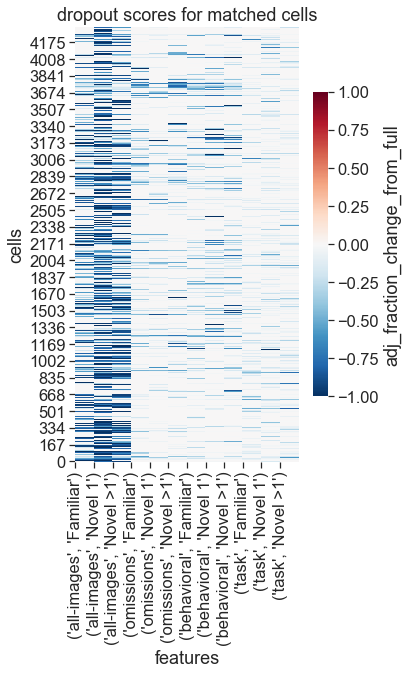

In [29]:
fig, ax = plt.subplots(figsize=(5,8))
ax = sns.heatmap(df.values, cmap='RdBu_r', ax=ax, vmin=-1, vmax=1,
                 robust=True, cbar_kws={"drawedges": False, "shrink": 0.7, "label": model_output_type})
ax.set_ylabel('cells')
ax.set_xlabel('features')
ax.set_title('dropout scores for matched cells')
ax.set_ylim(0, df.shape[0])
ax.set_xlim(0, df.shape[1])
ax.set_xticks(np.arange(0, df.shape[1]));
ax.set_xticklabels(df.keys(), rotation=90)
ax.set_xticklabels(df.keys(), rotation=90);

# cluster_divisions = np.where(np.diff(new_sorted_labels)==1)[0]
# for y in cluster_divisions:
#     ax.hlines(y, xmin=0, xmax=df.shape[1], color='k')

### single cell examples

C:\Users\marinag\Anaconda3\envs\visual_behavior_sdk\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


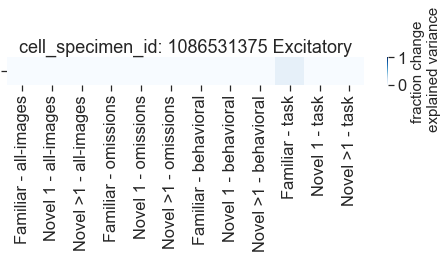

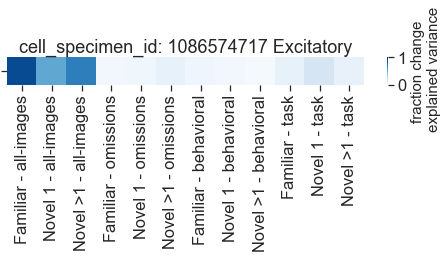

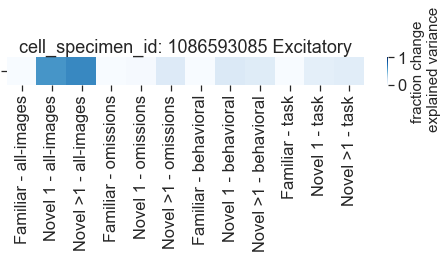

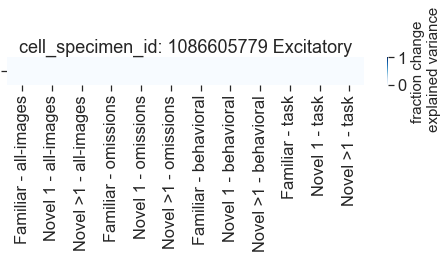

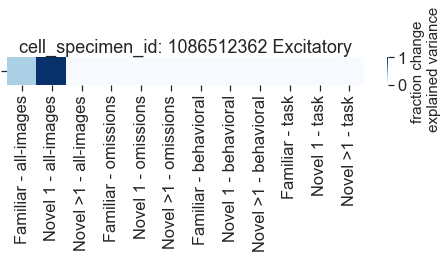

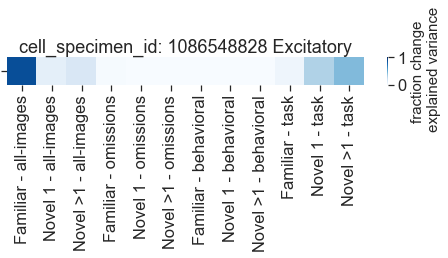

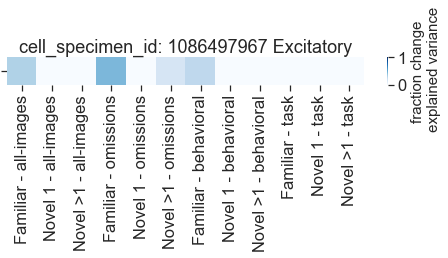

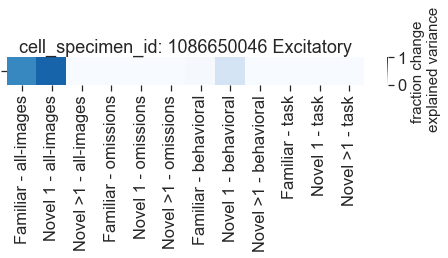

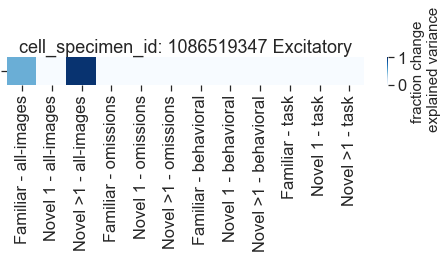

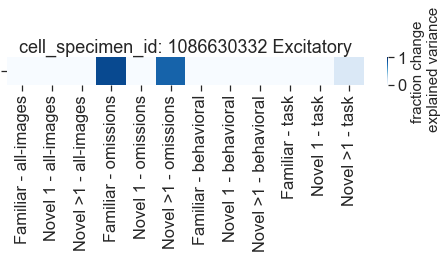

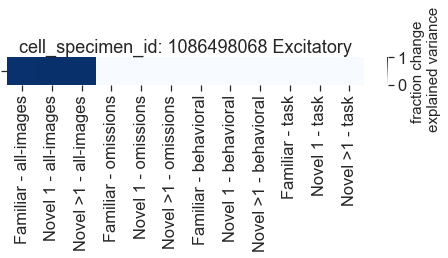

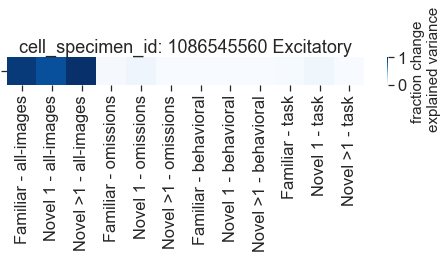

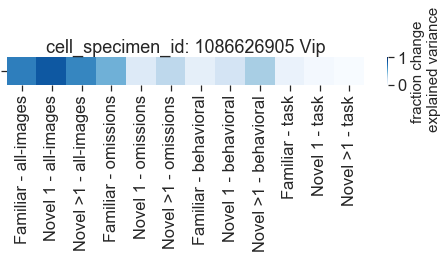

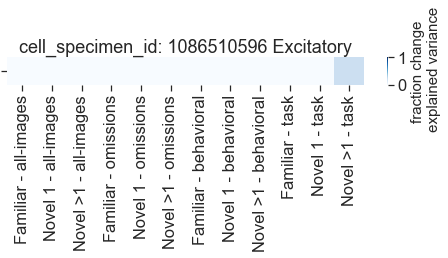

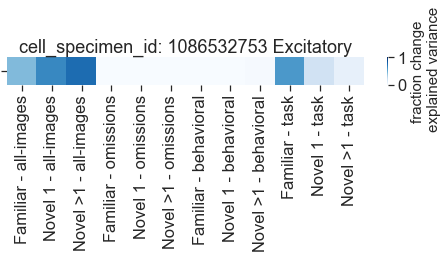

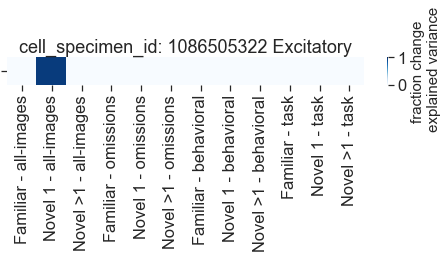

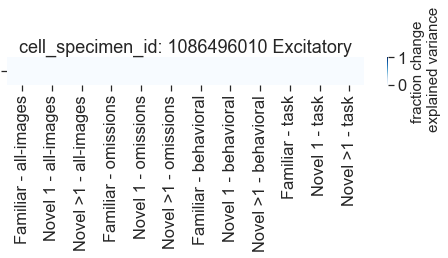

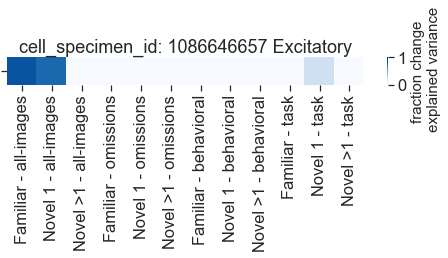

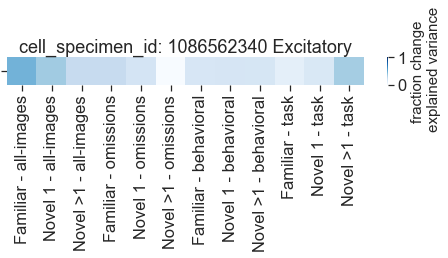

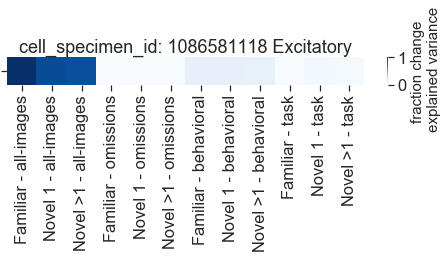

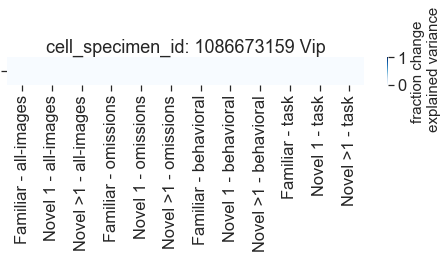

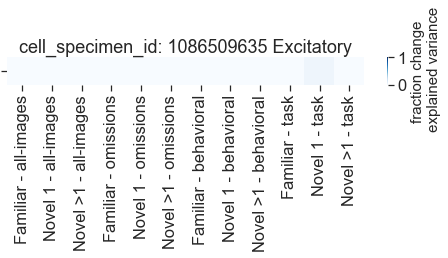

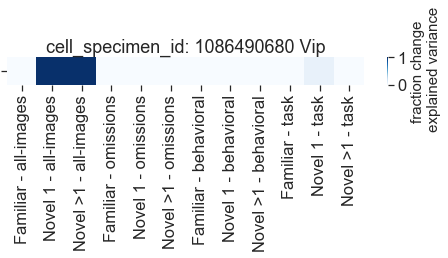

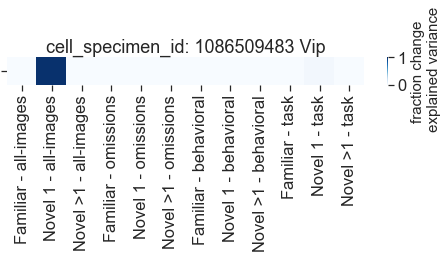

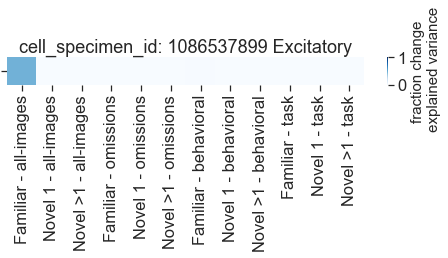

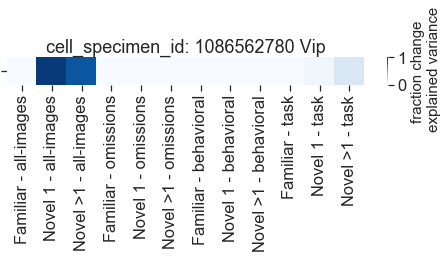

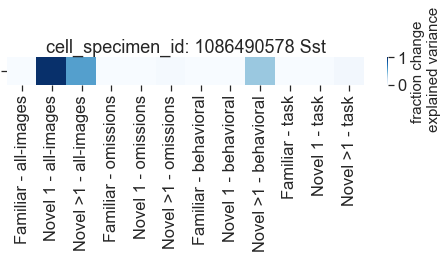

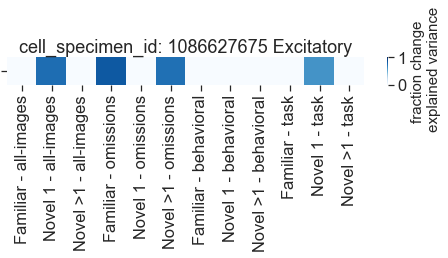

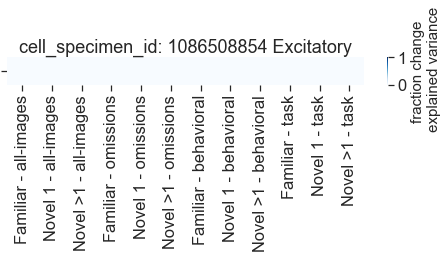

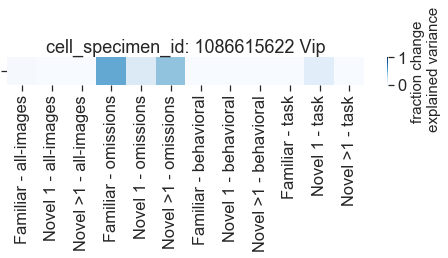

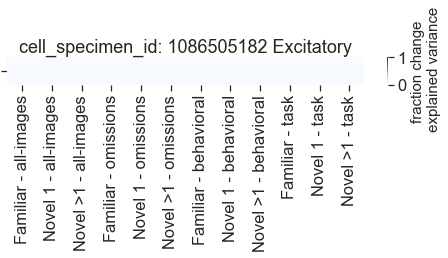

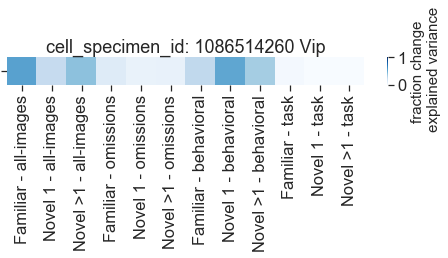

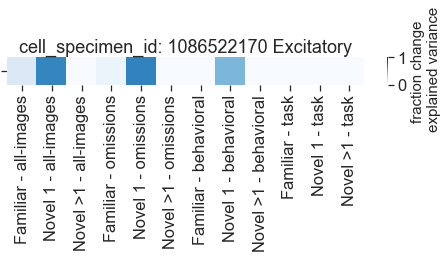

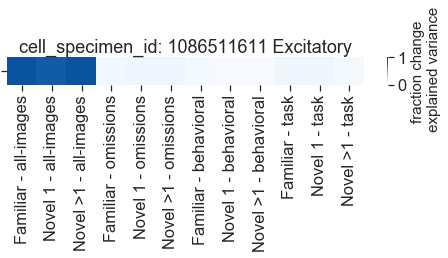

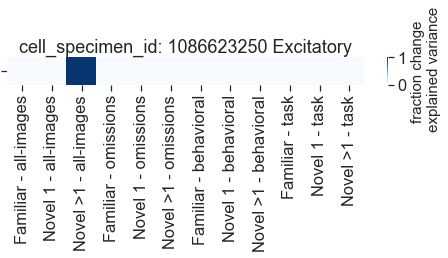

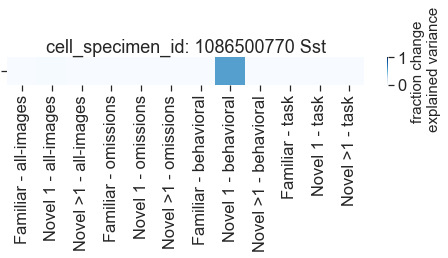

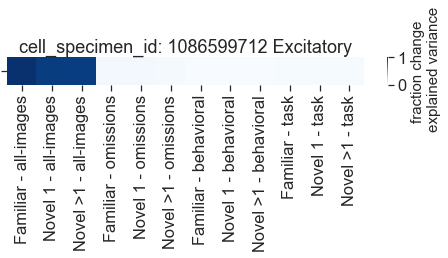

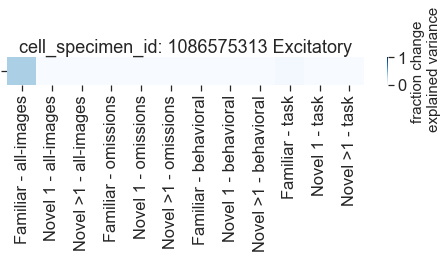

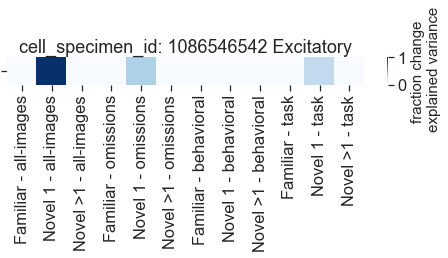

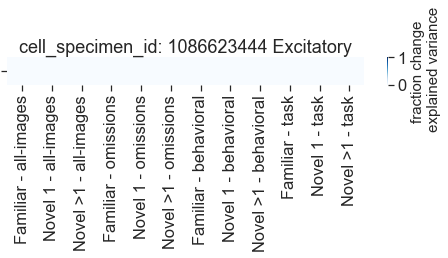

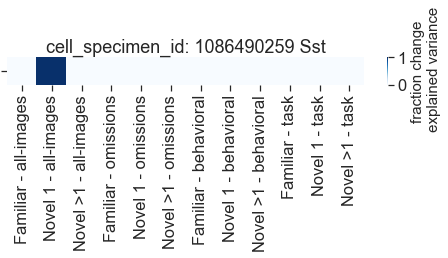

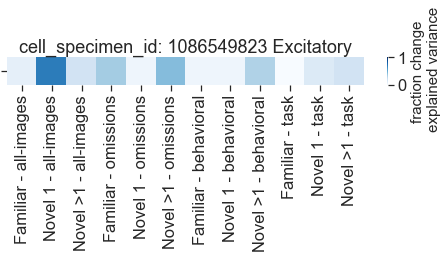

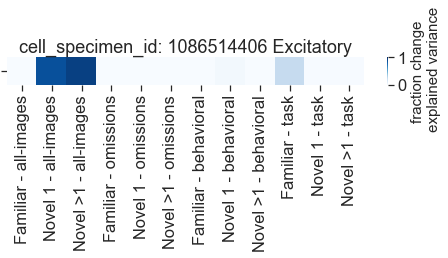

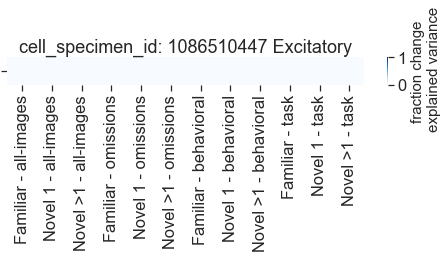

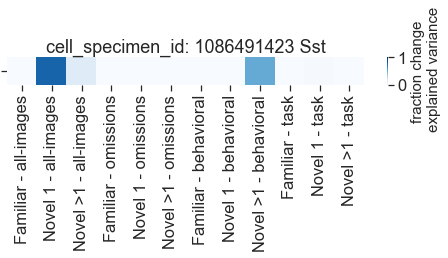

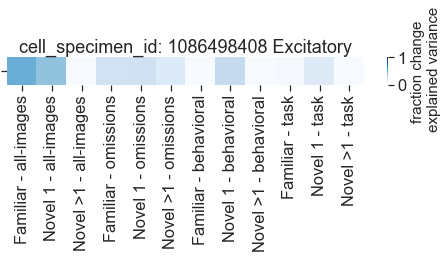

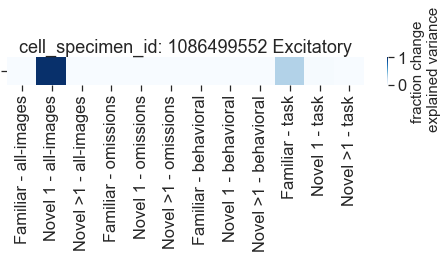

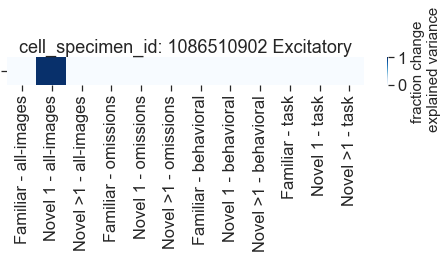

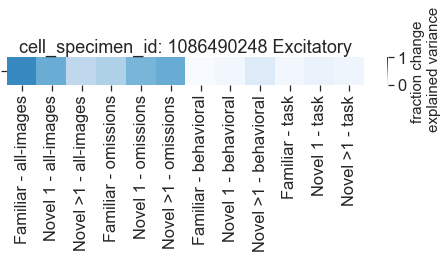

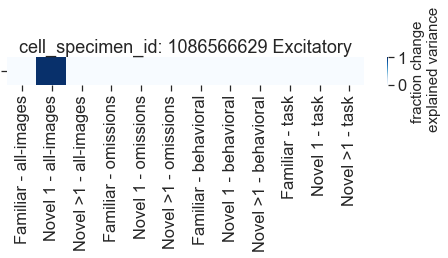

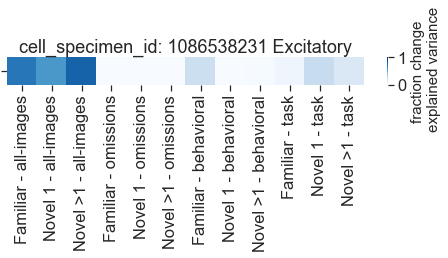

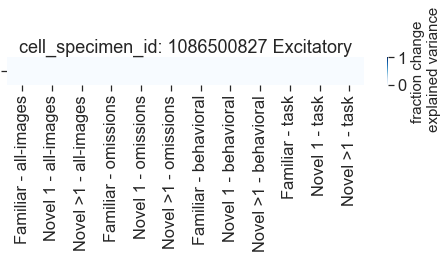

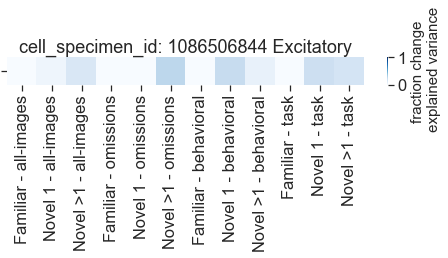

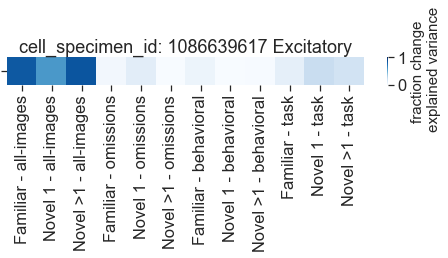

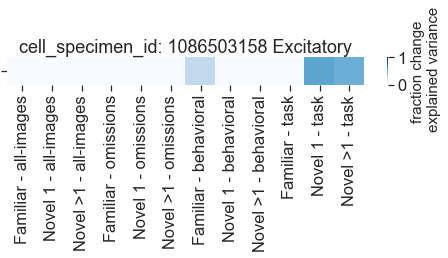

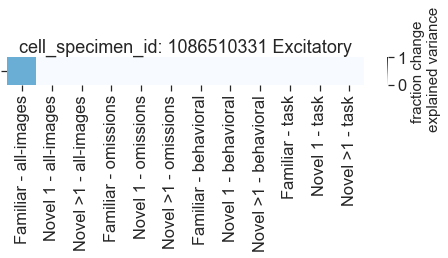

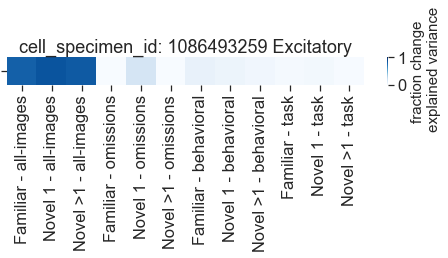

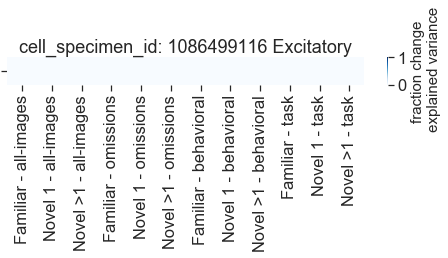

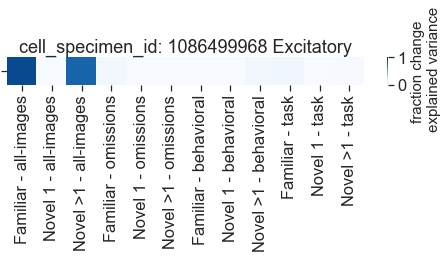

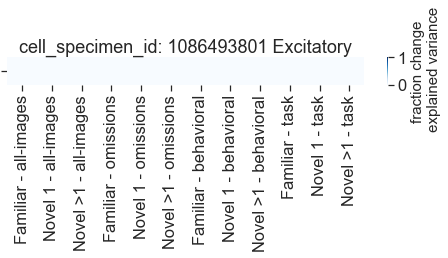

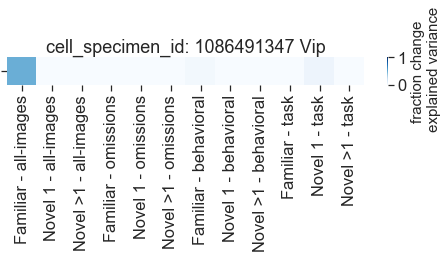

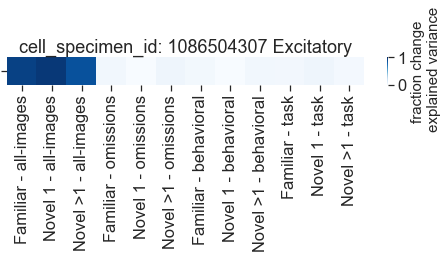

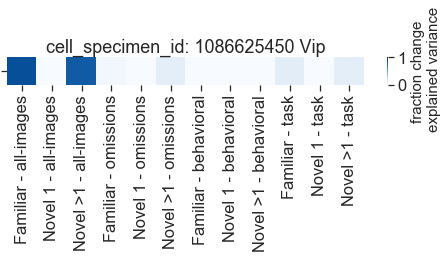

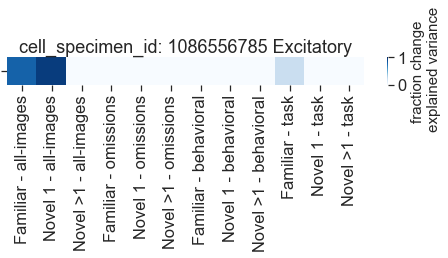

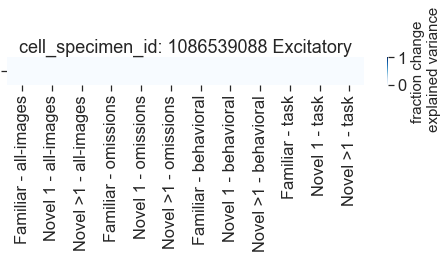

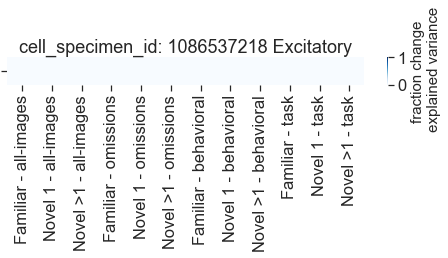

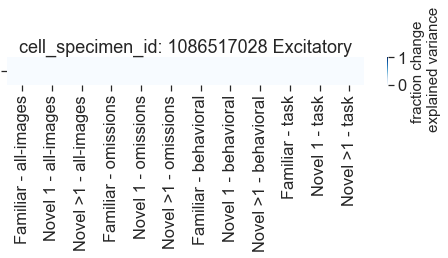

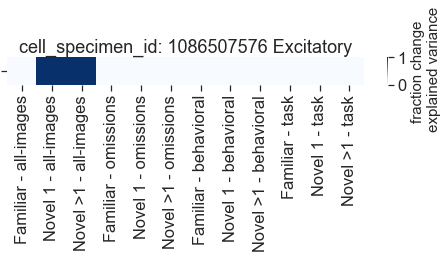

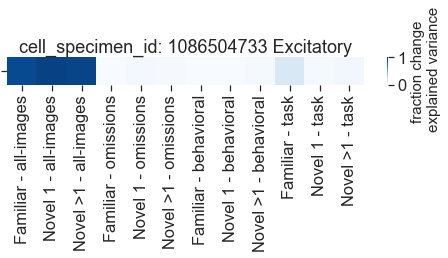

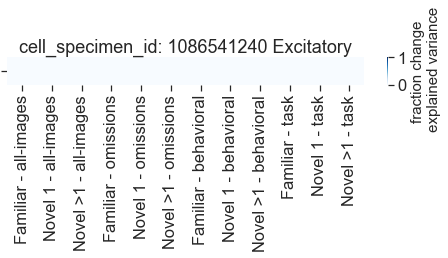

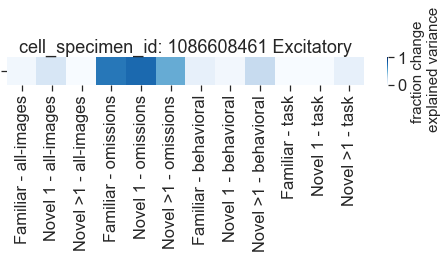

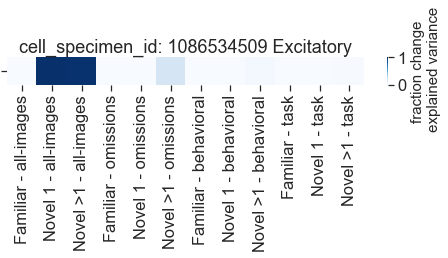

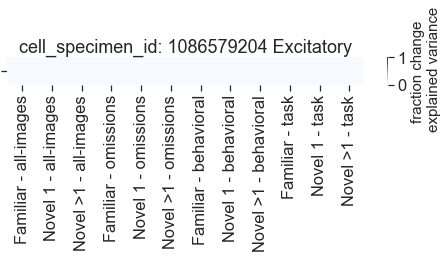

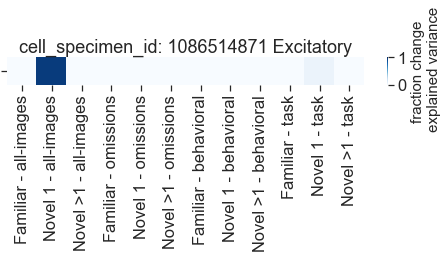

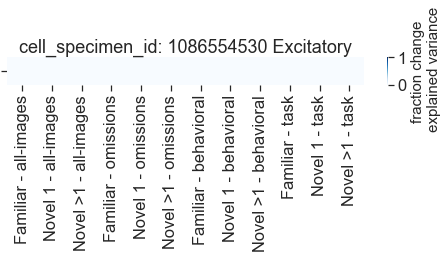

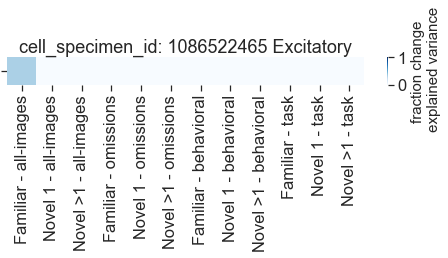

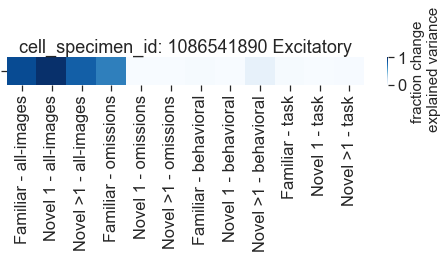

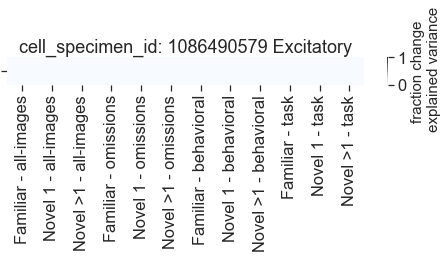

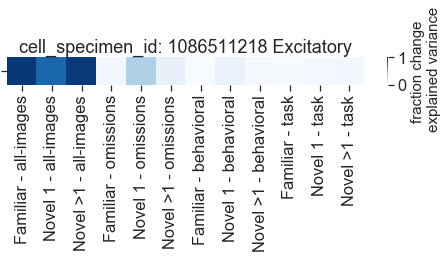

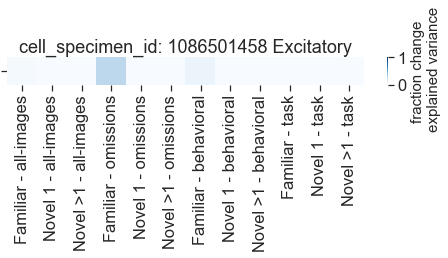

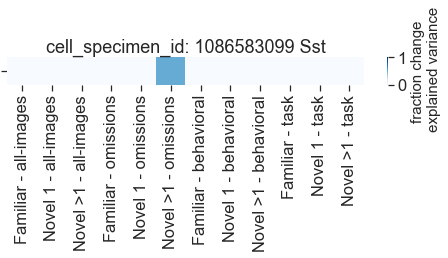

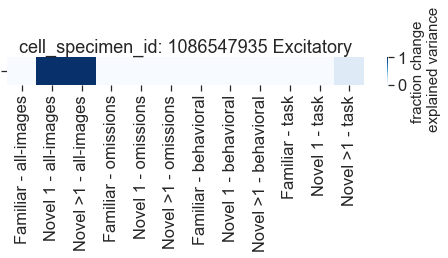

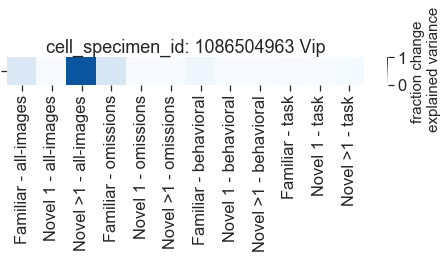

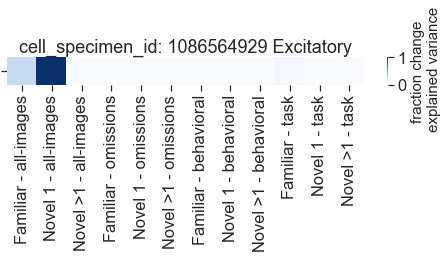

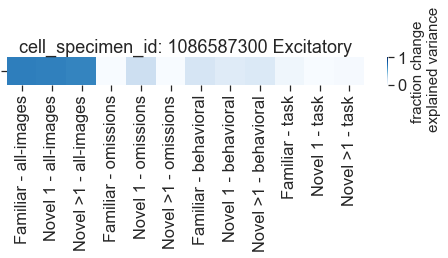

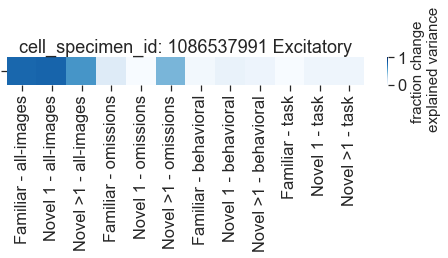

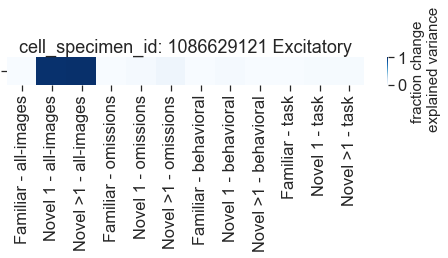

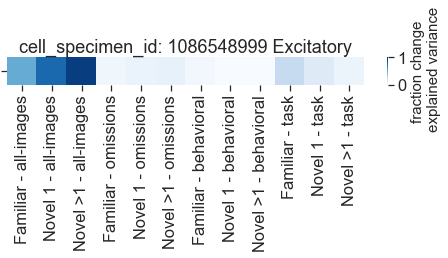

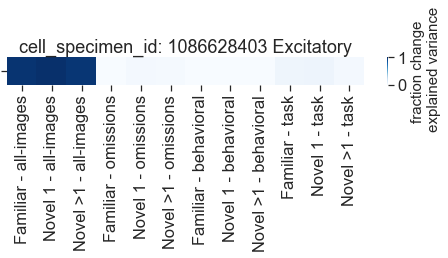

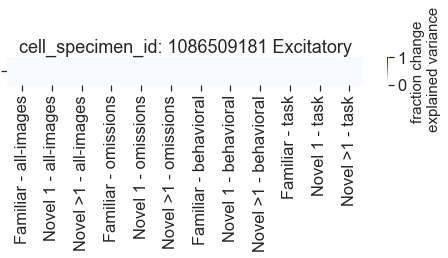

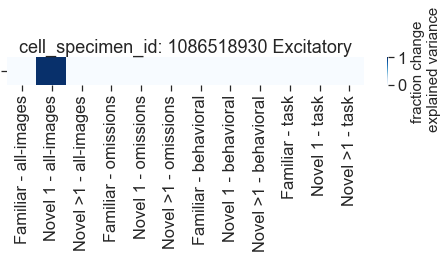

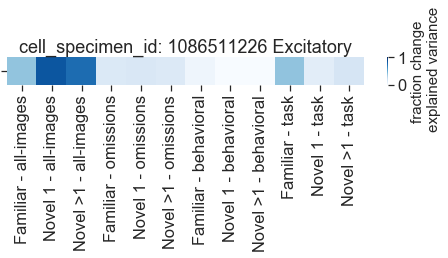

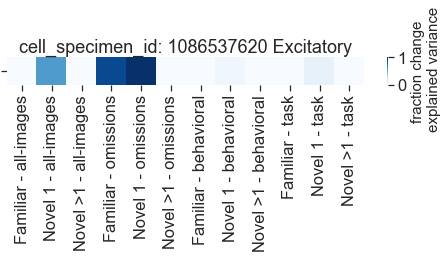

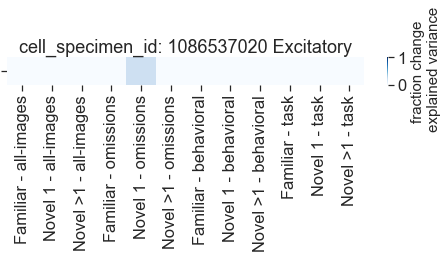

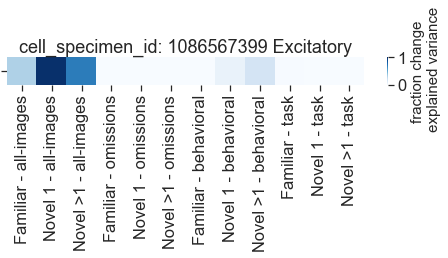

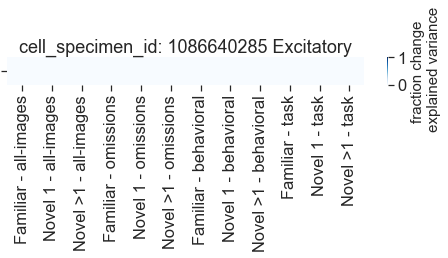

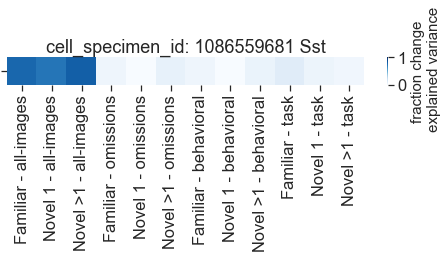

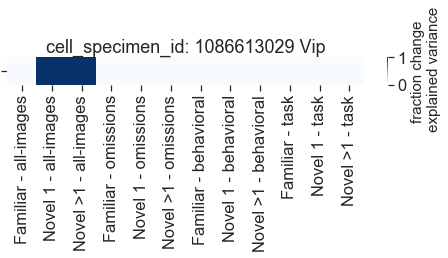

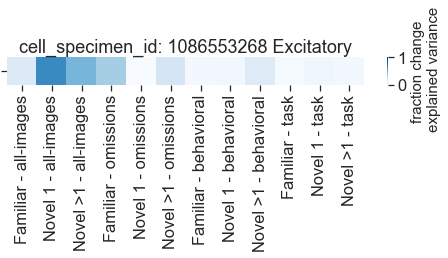

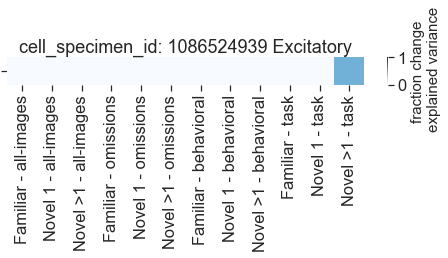

In [36]:
cell_specimen_ids = df.index.values
np.random.shuffle(cell_specimen_ids)

for cell_specimen_id in cell_specimen_ids[:100]:
    cdf = df.loc[cell_specimen_id].copy()
    cdf = pd.DataFrame(cdf)
    cell_type = rspm[rspm.cell_specimen_id==cell_specimen_id].cell_type.values[0]
    cell_type = cell_type.split(' ')[0]

    fig, ax = plt.subplots(figsize=(8,0.5))
    ax = sns.heatmap(cdf.T.abs(), cmap='Blues', ax=ax, vmin=0, vmax=1,
                     robust=True, cbar_kws={"drawedges": False, "shrink": 1, "label": 'fraction change\n explained variance'})
    ax.figure.axes[-1].yaxis.label.set_size(15)
    # ax.set_ylabel('cell_specimen_id')
    ax.set_xlabel('')
    ax.set_title('cell_specimen_id: '+str(cell_specimen_id)+' '+cell_type)
    ax.set_ylim(0, cdf.shape[1])
    ax.set_xlim(0, cdf.shape[0])
    ax.set_xticks(np.arange(0.5, cdf.shape[0]+0.5));
    # ax.set_xticklabels(cdf.keys(), rotation=90);
    ax.set_xticklabels([key[1]+' - '+key[0] for key in list(cdf.index)], rotation=90);
    ax.set_yticklabels('')
    fig.tight_layout
    # cluster_divisions = np.where(np.diff(new_sorted_labels)==1)[0]
    # for y in cluster_divisions:
    #     ax.hlines(y, xmin=0, xmax=df.shape[1], color='k')

### selecting number of clusters for kmeans

In [34]:
from visual_behavior.dimensionality_reduction import clustering as vba_clust
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering

In [35]:
X = df.copy()


In [34]:
# silhouette_scores = vba_clust.get_silhouette_scores(X, model=KMeans, 
#                                                     n_clusters=np.arange(2, 30), 
#                                                     metric='euclidean', 
#                                                     n_boots=20)

n 2 clusters mean score = 0.33323900669393264
n 3 clusters mean score = 0.3284741678148867
n 4 clusters mean score = 0.3469535247852161
n 5 clusters mean score = 0.3883026617590547
n 6 clusters mean score = 0.4108500052295675
n 7 clusters mean score = 0.4310574387938442
n 8 clusters mean score = 0.44288073394685856
n 9 clusters mean score = 0.43948503141041384
n 10 clusters mean score = 0.44161095796386796
n 11 clusters mean score = 0.439865925983942
n 12 clusters mean score = 0.43965779965797075
n 13 clusters mean score = 0.42869092244139073
n 14 clusters mean score = 0.43032223884133647
n 15 clusters mean score = 0.42558559141468466
n 16 clusters mean score = 0.42877260430863984
n 17 clusters mean score = 0.4293408725483074
n 18 clusters mean score = 0.4280499839602527
n 19 clusters mean score = 0.42629714885791603
n 20 clusters mean score = 0.4253769891563234
n 21 clusters mean score = 0.4232877190006053
n 22 clusters mean score = 0.4217761894967861
n 23 clusters mean score = 0.4186

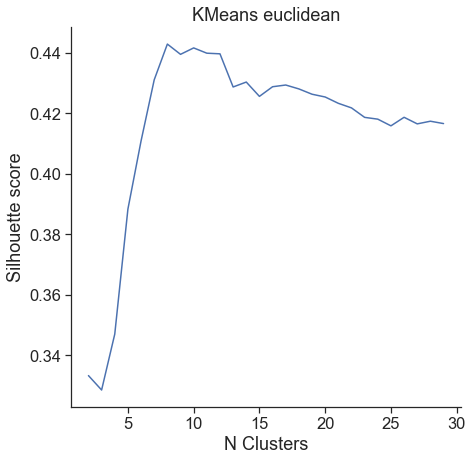

In [36]:
fig, ax = vba_clust.plot_silhouette_scores(X, model=KMeans, n_clusters=np.arange(2, 30), metric='euclidean', n_boots=20,
                         model_output_type='KMeans euclidean')

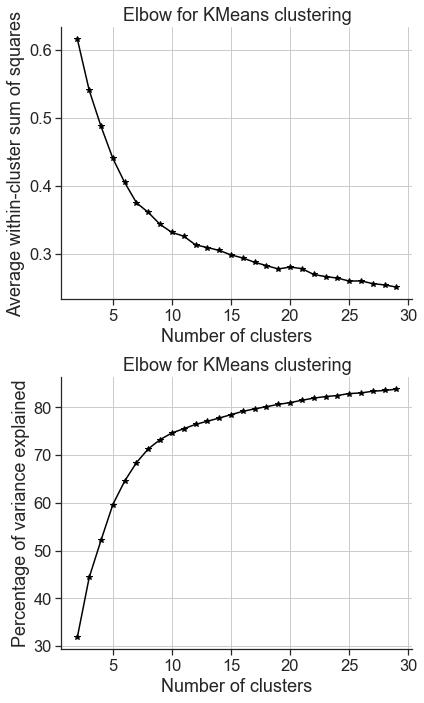

In [37]:
fig, ax = plt.subplots(2, 1, figsize=(6, 10))
vba_clust.get_elbow_plots(X, n_clusters=np.arange(2, 30), ax=ax)
fig.tight_layout()

### silhouette for spectral clustering

n 2 clusters mean score = 0.3299985479708643
n 3 clusters mean score = 0.32139736179851836
n 4 clusters mean score = 0.34102338934007437
n 5 clusters mean score = 0.37646355059154446
n 6 clusters mean score = 0.3931172753270887
n 7 clusters mean score = 0.3993387613724294
n 8 clusters mean score = 0.4150649522479261
n 9 clusters mean score = 0.4121482218081113
n 10 clusters mean score = 0.42268734219580395
n 11 clusters mean score = 0.41064029255742474
n 12 clusters mean score = 0.42582893721880105
n 13 clusters mean score = 0.4234188971698375
n 14 clusters mean score = 0.4233541188447549
n 15 clusters mean score = 0.4067928864145074
n 16 clusters mean score = 0.40195419884069394
n 17 clusters mean score = 0.40262918255233515
n 18 clusters mean score = 0.39197086403760817
n 19 clusters mean score = 0.39646060645157866
n 20 clusters mean score = 0.39200525765456934
n 21 clusters mean score = 0.3898549151378403
n 22 clusters mean score = 0.3959430608305673
n 23 clusters mean score = 0.39

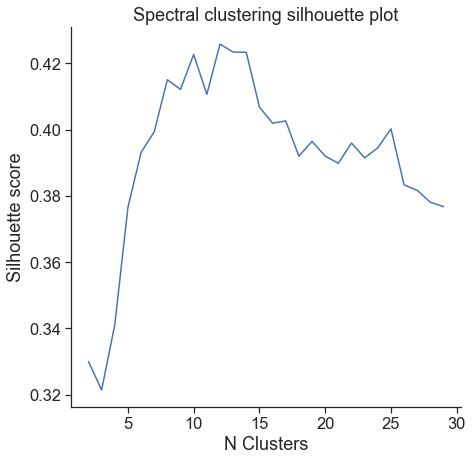

In [40]:
fig, ax = vba_clust.plot_silhouette_scores(X, model=SpectralClustering, n_clusters=np.arange(2, 30), metric='euclidean', n_boots=20,
                         model_output_type='Spectral clustering silhouette plot')

In [ ]:
# %time
# spec_sil_scores_40 = vba_clust.get_silhouette_scores(X, model=SpectralClustering, 
#                                         n_clusters=np.arange(2, 25), 
#                                         metric='euclidean', 
#                                         n_boots=40)

In [ ]:
# plt.plot(np.arange(2, 25),spec_sil_scores, 'k*-')
# plt.xlabel('N cluster')
# plt.ylabel('Silhouette score')
# plt.grid()

### Cluster with k-means

#### use k=15 given plots above

In [41]:
from sklearn.cluster import KMeans

X = df.copy()

kmeans = KMeans(n_clusters=13, random_state=0).fit(X)

In [42]:
kmeans.cluster_centers_.shape


(13, 12)

#### Get cluster labels, then sort dropouts in cluster order

In [43]:
labels = kmeans.labels_
sort_order = np.argsort(labels)
sorted_labels = labels[sort_order]

In [44]:
cluster_df = df.copy()
cluster_df['cluster_id'] = labels

### spectral

In [ ]:
# sc = SpectralClustering(n_clusters=13, assign_labels='discretize').fit(X)
# labels = sc.labels_

### sort clusters and plot

In [45]:
mean_df = cluster_df.groupby(['cluster_id']).mean()
sorted_mean_df = mean_df.sort_values(by=[('all-images', 'Novel 1'),('omissions', 'Novel 1'), ('behavioral', 'Novel 1'), ('task', 'Novel 1')])
cluster_order = sorted_mean_df.index.values

new_order = np.argsort(cluster_order)
new_labels = np.asarray([new_order[label] for label in labels])
new_sort_order = np.argsort(new_labels)
new_sorted_labels = new_labels[new_sort_order]

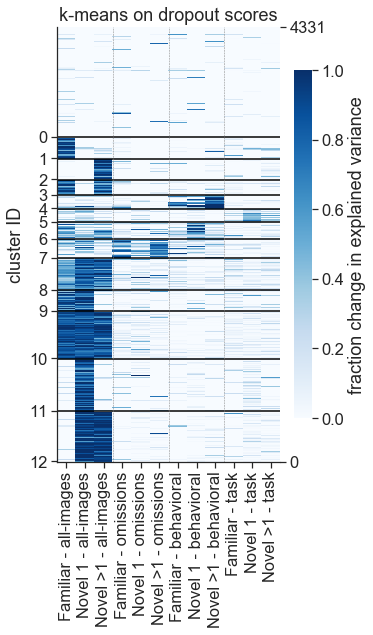

In [200]:
# plot dropout scores sorted by new order
fig, ax = plt.subplots(figsize=(5,8))
df = df.drop(columns=['agglo_cluster_id'])
ax = sns.heatmap(df.abs().values[new_sort_order], cmap='Blues', ax=ax, vmin=0, vmax=1,
                 robust=True, cbar_kws={"drawedges": False, "shrink": 0.8, "label": 'fraction change in explained variance'})
ax.set_ylabel('cells')
ax.set_xlabel('features')
ax.set_title('k-means on dropout scores')
ax.set_ylim(0, df.shape[0])
ax.set_xlim(0, df.shape[1])
ax.set_xticks(np.arange(0.5, df.shape[1]+0.5));
# ax.set_xticklabels(df.keys(), rotation=90)
ax.set_xticklabels([key[1]+' - '+key[0] for key in list(df.keys())], rotation=90);
# ax.set_xticklabels([key[0]+' - '+key[1] for key in list(df.keys())], rotation=90);
ax.set_xlabel('')
ax2 = ax.twinx()
ax2.set_yticks([0, len(df)])
ax2.set_yticklabels([0, len(df)])

cluster_divisions = np.where(np.diff(new_sorted_labels)==1)[0]
for y in cluster_divisions:
    ax.hlines(y, xmin=0, xmax=df.shape[1], color='k')
    
ax.set_yticks(np.hstack([np.asarray(0), cluster_divisions])+5);
ax.set_yticklabels(np.sort(cluster_df.cluster_id.unique())[::-1]);
ax.set_ylabel('cluster ID')

for x in np.arange(0, df.shape[0],3):
    ax.vlines(x, ymin=0, ymax=df.shape[0], color='gray', linestyle='--', linewidth=0.5)
    
# plt.gca().invert_yaxis()

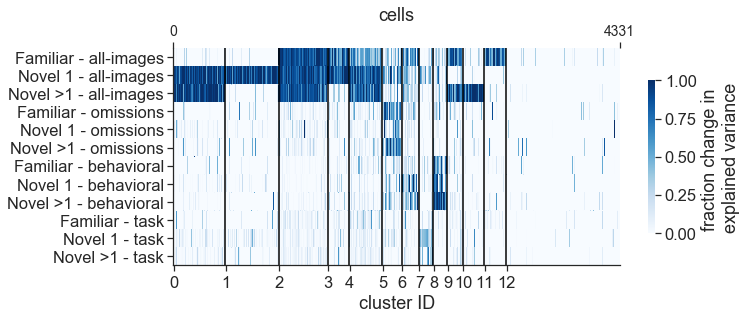

In [312]:
# invert axes
fig, ax = plt.subplots(figsize=(10,4))
ax = sns.heatmap(df.abs().values[new_sort_order].T, cmap='Blues', ax=ax, vmin=0, vmax=1,
                 robust=True, cbar_kws={"drawedges": False, "shrink": 0.7, "label": 'fraction change in \nexplained variance'})

# ax.set_title('clustering on single cell changes in coding across sessions')
ax.set_xlim(0, df.shape[0])

ax2 = ax.twiny()
ax2.set_ylabel('')
ax2.set_xlabel('cells')
ax2.set_ylim(0, df.shape[1])
ax2.set_yticks(np.arange(0.5, df.shape[1]+0.5));
# ax.set_yticklabels(df.keys(), rotation=0)
ax.set_yticklabels([key[1]+' - '+key[0] for key in list(df.keys())], rotation=0);

ax2.set_xticks([0, len(df)])
ax2.set_xticklabels([0, len(df)], fontsize=14)

# ax2.set_xticks(np.arange(0, len(df), 100))
# ax2.set_xticklabels(np.arange(0, len(df), 100), fontsize=12)

cluster_divisions = np.where(np.diff(new_sorted_labels)==1)[0]
for x in cluster_divisions:
    ax.vlines(x, ymin=0, ymax=df.shape[1], color='k')
    
ax.set_xticks(np.hstack([np.asarray(0), cluster_divisions])+5);
ax.set_xticklabels(np.sort(cluster_df.cluster_id.unique()), rotation=0);
ax.set_xlabel('cluster ID')

plt.gca().invert_yaxis()

### co-clustering

In [47]:
X = df.copy()

In [48]:
%time
labels = vba_clust.get_labels_for_coclust_matrix(X = X,
                                           model = KMeans,
                                           nboot = np.arange(100), n_clusters = 13)

Wall time: 0 ns


In [49]:
# make coClustering matrix (also exists in vba_clust but needs debugging)
coClust_matrix = []
nboot = np.arange(100)
for i in range(np.shape(labels)[1]): # get cluster id of this observation
    this_coClust_matrix = []
    for j in nboot: # find other observations with this cluster id
        clust_id = labels[j][i]
        this_coClust_matrix.append(labels[j] == clust_id)
    coClust_matrix.append(np.sum(this_coClust_matrix, axis=0) / max(nboot))

In [50]:
coClust_matrix = np.array(coClust_matrix)
# save coClust matrix

In [145]:
co_clustering_df = pd.DataFrame(data=coClust_matrix, columns=df.index, index=df.index)

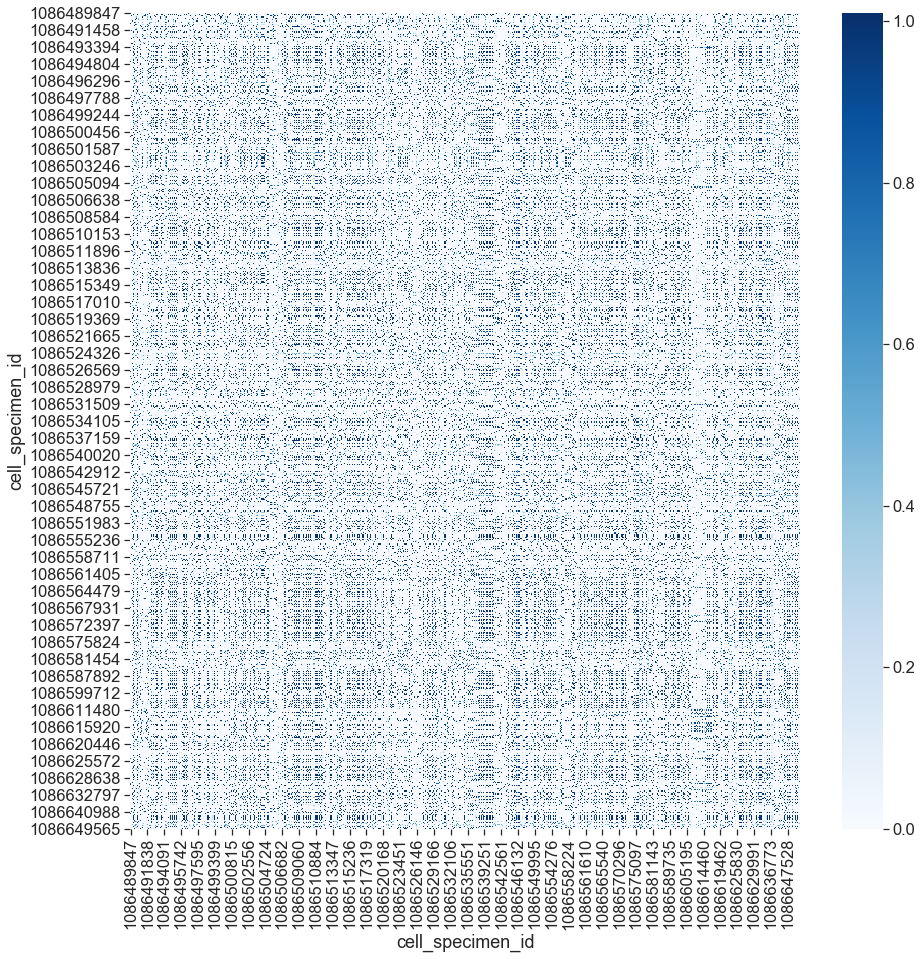

In [146]:
fig, ax = plt.subplots(1,1, figsize=(15,15))
sns.heatmap(co_clustering_df, ax=ax, cmap = "Blues")

### clustering the co-clustering matrix

In [250]:
df

all-images                     omissions                      \
experience_level   Familiar   Novel 1  Novel >1  Familiar   Novel 1  Novel >1   
cell_specimen_id                                                                
1086489847         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1086489860         0.000000 -0.897779  0.000000  0.000000 -0.131552  0.000000   
1086489891         0.000000 -0.483451  0.000000 -0.715705 -0.397531  0.000000   
1086489976        -0.741136  0.000000 -0.873052  0.000000  0.000000  0.000000   
1086490002        -0.734985  0.000000 -0.543915 -0.057500  0.000000  0.000000   
...                     ...       ...       ...       ...       ...       ...   
1086673279        -0.245728 -0.500072 -0.666845 -0.099889 -0.235234 -0.103906   
1086673299         0.000000 -0.789095 -0.583886  0.000000 -0.057658  0.000000   
1086673376        -0.570583 -0.702353 -0.178423 -0.169668 -0.082179 -0.290851   
1086673402         0.000000 -0.115200 -0.024532 -0.123837  0.000000  0.000000   
1086673591         0.000000  0.000000 -0.031346 -0.022509  0.000000  0.000000   

                 behavioral                          task                      
experience_level   Familiar   Novel 1  Novel >1  Familiar   Novel 1  Novel >1  
cell_specimen_id                                                               
1086489847        -0.897361  0.000000 -1.000000 -0.006544 -0.044886  0.000000  
1086489860         0.000000  0.000000  0.000000  0.000000 -0.037784  0.000000  
1086489891        -0.160694 -0.303837  0.000000  0.000000 -0.139572  0.000000  
1086489976         0.000000  0.000000  0.000000  0.000000  0.000000 -0.017138  
1086490002        -0.037985  0.000000  0.000000 -0.006437  0.000000  0.000000  
...                     ...       ...       ...       ...       ...       ...  
1086673279        -0.392409 -0.026755 -0.223648 -0.173769 -0.182667 -0.045238  
1086673299         0.000000 -0.028879 -0.117863  0.000000  0.000000 -0.224092  
1086673376        -0.228321 -0.030290 -0.467600 -0.102942 -0.029760 -0.062910  
1086673402        -1.000000 -0.196831 -0.344631 -0.445579 -0.373921 -0.146899  
1086673591        -0.472199  0.000000 -0.603700 -0.168176  0.000000 -0.102906  

[4331 rows x 12 columns]

In [253]:
df

all-images                     omissions                      \
experience_level   Familiar   Novel 1  Novel >1  Familiar   Novel 1  Novel >1   
cell_specimen_id                                                                
1086489847         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1086489860         0.000000 -0.897779  0.000000  0.000000 -0.131552  0.000000   
1086489891         0.000000 -0.483451  0.000000 -0.715705 -0.397531  0.000000   
1086489976        -0.741136  0.000000 -0.873052  0.000000  0.000000  0.000000   
1086490002        -0.734985  0.000000 -0.543915 -0.057500  0.000000  0.000000   
...                     ...       ...       ...       ...       ...       ...   
1086673279        -0.245728 -0.500072 -0.666845 -0.099889 -0.235234 -0.103906   
1086673299         0.000000 -0.789095 -0.583886  0.000000 -0.057658  0.000000   
1086673376        -0.570583 -0.702353 -0.178423 -0.169668 -0.082179 -0.290851   
1086673402         0.000000 -0.115200 -0.024532 -0.123837  0.000000  0.000000   
1086673591         0.000000  0.000000 -0.031346 -0.022509  0.000000  0.000000   

                 behavioral                          task                      
experience_level   Familiar   Novel 1  Novel >1  Familiar   Novel 1  Novel >1  
cell_specimen_id                                                               
1086489847        -0.897361  0.000000 -1.000000 -0.006544 -0.044886  0.000000  
1086489860         0.000000  0.000000  0.000000  0.000000 -0.037784  0.000000  
1086489891        -0.160694 -0.303837  0.000000  0.000000 -0.139572  0.000000  
1086489976         0.000000  0.000000  0.000000  0.000000  0.000000 -0.017138  
1086490002        -0.037985  0.000000  0.000000 -0.006437  0.000000  0.000000  
...                     ...       ...       ...       ...       ...       ...  
1086673279        -0.392409 -0.026755 -0.223648 -0.173769 -0.182667 -0.045238  
1086673299         0.000000 -0.028879 -0.117863  0.000000  0.000000 -0.224092  
1086673376        -0.228321 -0.030290 -0.467600 -0.102942 -0.029760 -0.062910  
1086673402        -1.000000 -0.196831 -0.344631 -0.445579 -0.373921 -0.146899  
1086673591        -0.472199  0.000000 -0.603700 -0.168176  0.000000 -0.102906  

[4331 rows x 12 columns]

### make df_meta

In [262]:
ct = cells_table.drop_duplicates(subset=['cell_specimen_id', 'ophys_container_id'])
ct = ct.set_index('cell_specimen_id')

df_meta = df.join(ct, on='cell_specimen_id', how='left')
df_meta

C:\Users\marinag\AppData\Roaming\Python\Python37\site-packages\pandas\core\reshape\merge.py:617: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


(all-images, Familiar)  (all-images, Novel 1)  \
cell_specimen_id                                                  
1086489847                      0.000000               0.000000   
1086489860                      0.000000              -0.897779   
1086489891                      0.000000              -0.483451   
1086489976                     -0.741136               0.000000   
1086490002                     -0.734985               0.000000   
...                                  ...                    ...   
1086673279                     -0.245728              -0.500072   
1086673299                      0.000000              -0.789095   
1086673376                     -0.570583              -0.702353   
1086673402                      0.000000              -0.115200   
1086673591                      0.000000               0.000000   

                  (all-images, Novel >1)  (omissions, Familiar)  \
cell_specimen_id                                                  
1086489847                      0.000000               0.000000   
1086489860                      0.000000               0.000000   
1086489891                      0.000000              -0.715705   
1086489976                     -0.873052               0.000000   
1086490002                     -0.543915              -0.057500   
...                                  ...                    ...   
1086673279                     -0.666845              -0.099889   
1086673299                     -0.583886               0.000000   
1086673376                     -0.178423              -0.169668   
1086673402                     -0.024532              -0.123837   
1086673591                     -0.031346              -0.022509   

                  (omissions, Novel 1)  (omissions, Novel >1)  \
cell_specimen_id                                                
1086489847                    0.000000               0.000000   
1086489860                   -0.131552               0.000000   
1086489891                   -0.397531               0.000000   
1086489976                    0.000000               0.000000   
1086490002                    0.000000               0.000000   
...                                ...                    ...   
1086673279                   -0.235234              -0.103906   
1086673299                   -0.057658               0.000000   
1086673376                   -0.082179              -0.290851   
1086673402                    0.000000               0.000000   
1086673591                    0.000000               0.000000   

                  (behavioral, Familiar)  (behavioral, Novel 1)  \
cell_specimen_id                                                  
1086489847                     -0.897361               0.000000   
1086489860                      0.000000               0.000000   
1086489891                     -0.160694              -0.303837   
1086489976                      0.000000               0.000000   
1086490002                     -0.037985               0.000000   
...                                  ...                    ...   
1086673279                     -0.392409              -0.026755   
1086673299                      0.000000              -0.028879   
1086673376                     -0.228321              -0.030290   
1086673402                     -1.000000              -0.196831   
1086673591                     -0.472199               0.000000   

                  (behavioral, Novel >1)  (task, Familiar)  ...  area_depth  \
cell_specimen_id                                            ...               
1086489847                     -1.000000         -0.006544  ...    VISp_175   
1086489860                      0.000000          0.000000  ...    VISp_175   
1086489891                      0.000000          0.000000  ...    VISp_175   
1086489976                      0.000000          0.000000  ...    VISp_290   
1086490002                      0.000000         -0.006437  ...    VISp_290   
...

In [57]:
row_colors = []
col_colors = []
colors = {'Sst-IRES-Cre': (0.6196078431372549, 0.8549019607843137, 0.8980392156862745),
              'Vip-IRES-Cre': (0.7725490196078432, 0.6901960784313725, 0.8352941176470589),
              'Slc17a7-IRES2-Cre': (1.0, 0.596078431372549, 0.5882352941176471),
              'VISp': sns.color_palette()[8],
              'VISl': sns.color_palette()[2]
         }
for cre in df_meta['cre_line'].values:
    row_colors.append(colors[cre])
for tar_str in df_meta['targeted_structure'].values:
    col_colors.append(colors[tar_str])


C:\Users\marinag\Anaconda3\envs\visual_behavior_sdk\lib\site-packages\seaborn\matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
C:\Users\marinag\Anaconda3\envs\visual_behavior_sdk\lib\site-packages\seaborn\matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


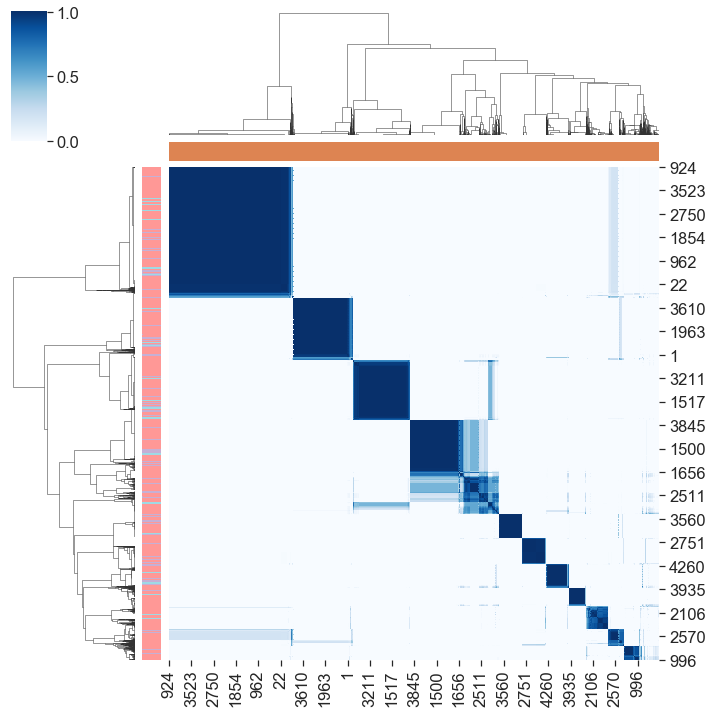

In [58]:
clust_map = sns.clustermap(coClust_matrix,cmap = 'Blues', row_colors=row_colors, col_colors=col_colors)

In [59]:
# get row order of the dendrogram 
order = clust_map.dendrogram_row.reordered_ind

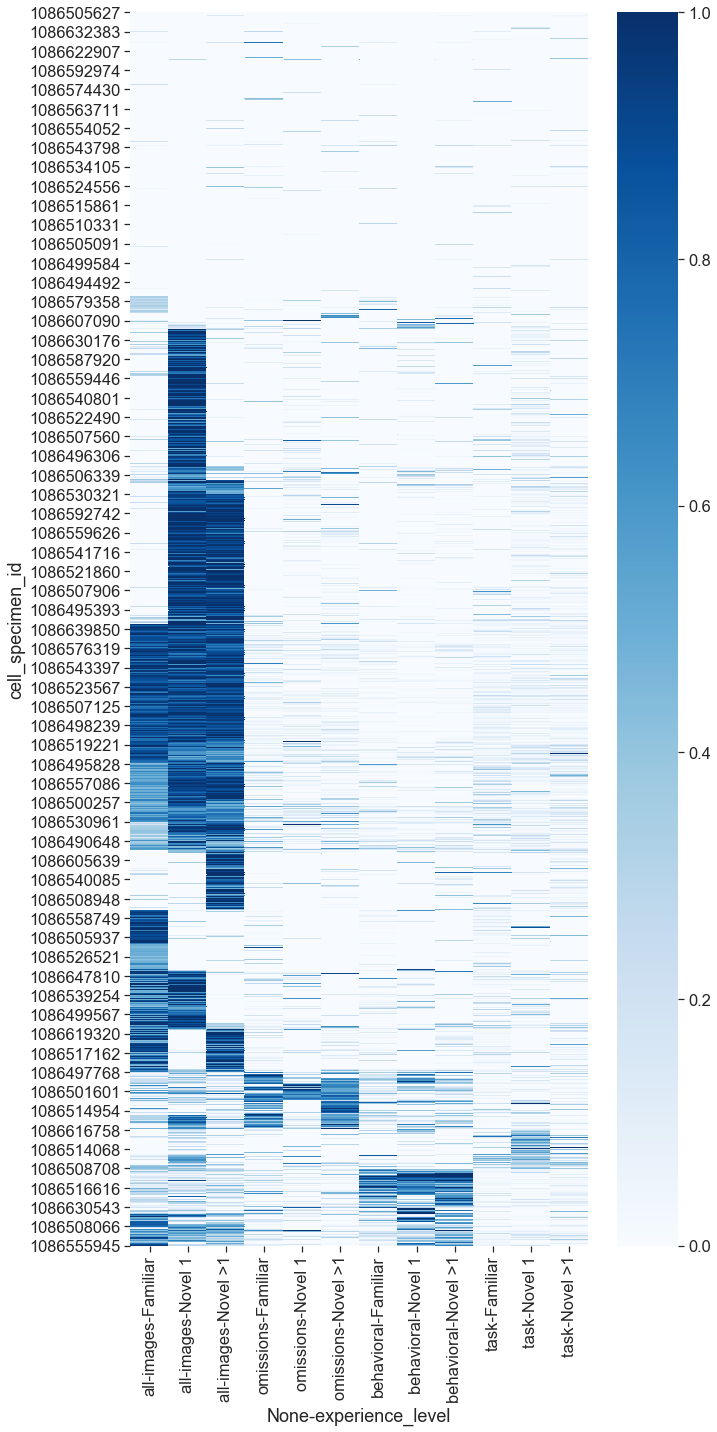

In [65]:
fig, ax = plt.subplots(1,1, figsize=(10, 20))
sns.heatmap(df.iloc[order].abs(), cmap='Blues')
plt.tight_layout()
#fig.savefig(os.path.join(fig_path, 'heatmap_of_coclust_order.png'))

### agglomerative clustering on co-clustering matrix 

In [147]:
from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=13, affinity='euclidean', linkage='average')
agglo_clust = cluster.fit_predict(co_clustering_df.values)

In [148]:
cluster_labels = agglo_clust

In [263]:
# df_meta.loc[:,'agglo_cluster_id'] = list(agglo_clust)
df_meta.loc[:,'cluster_id'] = list(cluster_labels)

In [150]:
cluster_counts = df_meta.groupby(['cluster_id']).count()

In [151]:
n_cells = df_meta.groupby(['cluster_id']).count()[[('all-images', 'Familiar')]].rename(columns={('all-images', 'Familiar'):'n_cells_in_cluster'})

n_cells_in_cluster
cluster_id                    
0                          306
1                          307
2                          525
3                          501
4                           26
5                          140
6                          480
7                          212
8                          202
9                          151
10                         196
11                         208
12                        1077

In [217]:
cluster_size_order = n_cells.sort_values(by='n_cells_in_cluster').index.values[::-1]

In [218]:
cluster_size_order

array([12,  2,  3,  6,  1,  0,  7, 11,  8, 10,  9,  5,  4], dtype=int64)

In [264]:
df_meta['new_cluster_id'] = [np.where(cluster_size_order==cluster_id)[0][0] for cluster_id in df_meta.cluster_id.values]

In [220]:
order = np.argsort(df_meta['new_cluster_id'].values)
cell_order = co_clustering_df.index.values[order][::-1]

co_clustering_df_sorted = co_clustering_df.reindex(columns=cell_order)
co_clustering_df_sorted = co_clustering_df_sorted.reindex(index=cell_order)

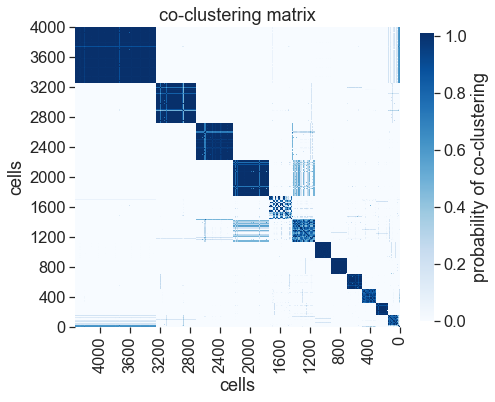

In [265]:
fig, ax = plt.subplots(1,1, figsize=(7,6))
ax = sns.heatmap(co_clustering_df_sorted, ax=ax, cmap = "Blues", square=True,
                 cbar_kws={'label':'probability of co-clustering', 'shrink':0.8})
ax.set_xticks(np.arange(0, co_clustering_df_sorted.shape[0], 400))
ax.set_xticklabels(np.arange(0, co_clustering_df_sorted.shape[0], 400))
ax.set_xlabel('cells')
ax.set_yticks(np.arange(0, co_clustering_df_sorted.shape[0], 400))
ax.set_yticklabels(np.arange(0, co_clustering_df_sorted.shape[0], 400))
ax.set_ylabel('cells')
ax.set_title('co-clustering matrix')
fig.tight_layout()
# 
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

### plot dropouts by cluster id

In [266]:
order = np.argsort(df_meta['new_cluster_id'].values)
cell_order = df.index.values[order]
cluster_id_order = df_meta['new_cluster_id'].values[order]

df_sorted = df.reindex(index=cell_order)
# df_sorted = df_sorted.drop(columns=['agglo_cluster_id'])

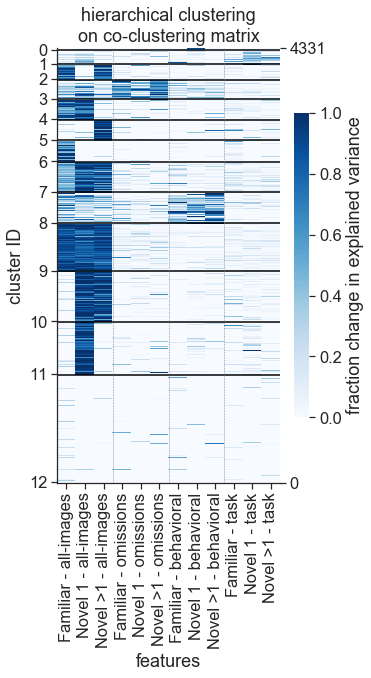

In [267]:
fig, ax = plt.subplots(figsize=(5,8))
ax = sns.heatmap(df_sorted.abs().values, cmap='Blues', ax=ax, vmin=0, vmax=1,
                 robust=True, cbar_kws={"drawedges": False, "shrink": 0.7, "label": 'fraction change in explained variance'})
ax.set_ylabel('cells')
ax.set_xlabel('features')
ax.set_title('hierarchical clustering\non co-clustering matrix')
ax.set_ylim(0, df_sorted.shape[0])
ax.set_xlim(0, df_sorted.shape[1])
ax.set_xticks(np.arange(0.5, df_sorted.shape[1]+0.5));
# ax.set_xticklabels(df.keys(), rotation=90)
ax.set_xticklabels([key[1]+' - '+key[0] for key in list(df_sorted.keys())], rotation=90);
# ax.set_xticklabels([key[0]+' - '+key[1] for key in list(df.keys())], rotation=90);
ax2 = ax.twinx()
ax2.set_yticks([0, len(df_sorted)])
ax2.set_yticklabels([0, len(df_sorted)])
ax2.set_xlabel('')

cluster_divisions = np.where(np.diff(df_meta.new_cluster_id.values[order])==1)[0]
for y in cluster_divisions:
    ax.hlines(y, xmin=0, xmax=df_sorted.shape[1], color='k')
    
ax.set_yticks(np.hstack([np.asarray(0), cluster_divisions])+5);
ax.set_yticklabels(np.sort(df_meta.new_cluster_id.unique())[::-1]);
ax.set_ylabel('cluster ID')

for x in np.arange(3, df_sorted.shape[0],3):
    ax.vlines(x, ymin=0, ymax=df_sorted.shape[0], color='gray', linestyle='--', linewidth=0.5)
    
# plt.gca().invert_yaxis()

### make cluster df which has dropouts and cluster ids and metadata

In [268]:
cluster_df = df_sorted.copy()
cluster_df['cluster_id'] = cluster_id_order

cluster_df = cluster_df.join(df_meta[['cell_type', 'targeted_structure', 'binned_depth']], on='cell_specimen_id')
# cluster_df = cluster_df.set_index('cell_specimen_id')

C:\Users\marinag\AppData\Roaming\Python\Python37\site-packages\pandas\core\reshape\merge.py:617: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


In [272]:
cluster_df['cluster_id'] = cluster_id_order

### What is the cre line composition of each cluster (using new sorted labels)? 

In [273]:
# cluster_df = pd.DataFrame(index=df_sorted.index, columns=['cluster_id'], data=new_labels)
print(len(cluster_df))
# merge with metadata
metadata = rspm[['cell_specimen_id', 'cell_type', 'imaging_depth', 'targeted_structure', 'binned_depth']]
cluster_df = cluster_df.merge(metadata, on='cell_specimen_id')
print(len(cluster_df))
cluster_df = cluster_df.drop_duplicates(subset='cell_specimen_id')
print(len(cluster_df))
cluster_df.head()


4331
18050
4331


cell_specimen_id  (all-images, Familiar)  (all-images, Novel 1)  \
0         1086587247                0.000000                    0.0   
4         1086618742                0.000000                    0.0   
7         1086503970                0.000000                    0.0   
11        1086618915                0.000000                    0.0   
15        1086524764               -0.023994                    0.0   

    (all-images, Novel >1)  (omissions, Familiar)  (omissions, Novel 1)  \
0                      0.0                    0.0                   0.0   
4                      0.0                    0.0                   0.0   
7                      0.0                    0.0                   0.0   
11                     0.0                    0.0                   0.0   
15                     0.0                    0.0                   0.0   

    (omissions, Novel >1)  (behavioral, Familiar)  (behavioral, Novel 1)  \
0                     0.0                0.000000                    0.0   
4                     0.0                0.000000                    0.0   
7                     0.0                0.000000                    0.0   
11                    0.0                0.000000                    0.0   
15                    0.0               -0.459284                    0.0   

    (behavioral, Novel >1)  ...  binned_depth_x     cell_type_y  \
0                      0.0  ...             275      Excitatory   
4                      0.0  ...             175      Excitatory   
7                      0.0  ...             175      Excitatory   
11                     0.0  ...             175      Excitatory   
15                     0.0  ...             275  Vip Inhibitory   

    imaging_depth_x  targeted_structure_y binned_depth_y cluster_id  \
0             275.0                  VISp          275.0          0   
4             175.0                  VISp          175.0          0   
7             175.0                  VISp          175.0          0   
11            175.0                  VISp          175.0          0   
15            225.0                  VISl          275.0          0   

         cell_type imaging_depth_y  targeted_structure binned_depth  
0       Excitatory           275.0                VISp        275.0  
4       Excitatory           175.0                VISp        175.0  
7       Excitatory           175.0                VISp        175.0  
11      Excitatory           175.0                VISp        175.0  
15  Vip Inhibitory           225.0                VISl        275.0  

[5 rows x 26 columns]

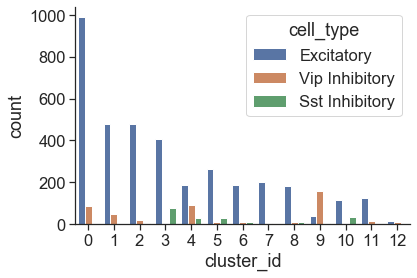

In [274]:
sns.countplot(data=cluster_df, x='cluster_id', hue='cell_type')

In [275]:
len(cluster_df)

4331

### What is the cluster breakdown for each cre line?

In [276]:
cluster_df = cluster_df.dropna()
len(cluster_df)

4331

In [277]:
total_per_cell_type = cluster_df.groupby(['cell_type']).count()[['cell_specimen_id']].rename(columns={'cell_specimen_id':'n_total'})
total_per_cell_type

n_total
cell_type              
Excitatory         3671
Sst Inhibitory      194
Vip Inhibitory      466

In [278]:
n_per_cluster = cluster_df.groupby(['cell_type', 'cluster_id']).count()[['cell_specimen_id']].rename(columns={'cell_specimen_id':'n_per_cluster'})
n_per_cluster = n_per_cluster.reset_index()

In [279]:
fraction_per_cluster = n_per_cluster.merge(total_per_cell_type, on=['cell_type'])
fraction_per_cluster['fraction'] = fraction_per_cluster.n_per_cluster.values/fraction_per_cluster.n_total.values

In [280]:
fraction_per_cluster

cell_type  cluster_id  n_per_cluster  n_total  fraction
0       Excitatory           0            991     3671  0.269954
1       Excitatory           1            477     3671  0.129937
2       Excitatory           2            480     3671  0.130755
3       Excitatory           3            405     3671  0.110324
4       Excitatory           4            187     3671  0.050940
5       Excitatory           5            264     3671  0.071915
6       Excitatory           6            189     3671  0.051485
7       Excitatory           7            201     3671  0.054753
8       Excitatory           8            183     3671  0.049850
9       Excitatory           9             37     3671  0.010079
10      Excitatory          10            116     3671  0.031599
11      Excitatory          11            126     3671  0.034323
12      Excitatory          12             15     3671  0.004086
13  Sst Inhibitory           1              2      194  0.010309
14  Sst Inhibitory           2              4      194  0.020619
15  Sst Inhibitory           3             75      194  0.386598
16  Sst Inhibitory           4             27      194  0.139175
17  Sst Inhibitory           5             30      194  0.154639
18  Sst Inhibitory           6             11      194  0.056701
19  Sst Inhibitory           8              8      194  0.041237
20  Sst Inhibitory           9              3      194  0.015464
21  Sst Inhibitory          10             32      194  0.164948
22  Sst Inhibitory          12              2      194  0.010309
23  Vip Inhibitory           0             86      466  0.184549
24  Vip Inhibitory           1             46      466  0.098712
25  Vip Inhibitory           2             17      466  0.036481
26  Vip Inhibitory           4             93      466  0.199571
27  Vip Inhibitory           5             12      466  0.025751
28  Vip Inhibitory           6             12      466  0.025751
29  Vip Inhibitory           7              7      466  0.015021
30  Vip Inhibitory           8             11      466  0.023605
31  Vip Inhibitory           9            156      466  0.334764
32  Vip Inhibitory          10              3      466  0.006438
33  Vip Inhibitory          11             14      466  0.030043
34  Vip Inhibitory          12              9      466  0.019313

In [281]:
import visual_behavior.visualization.utils as utils

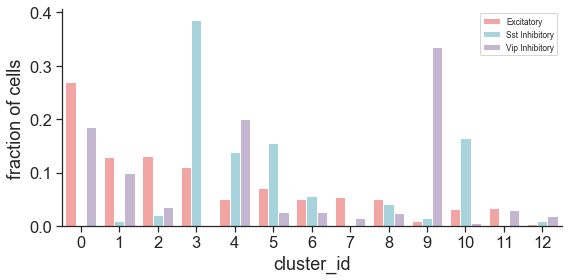

In [282]:
palette = utils.get_cre_line_colors()
cell_types = np.sort(cluster_df.cell_type.unique())

fig, ax = plt.subplots(figsize=(8,4))
ax = sns.barplot(data=fraction_per_cluster, x='cluster_id', y='fraction', hue='cell_type', palette=palette, ax=ax)
# ax.set_title('fraction of cells per cluster')
ax.set_ylabel('fraction of cells')
ax.legend(title='', fontsize='small')
fig.tight_layout()

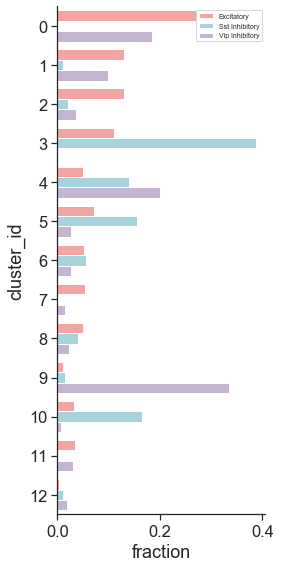

In [283]:
palette = utils.get_cre_line_colors()
cell_types = np.sort(cluster_df.cell_type.unique())

fig, ax = plt.subplots(figsize=(4,8))
ax = sns.barplot(data=fraction_per_cluster, y='cluster_id', x='fraction', hue='cell_type', 
                 palette=palette, orient='h', ax=ax)
# ax.set_title('fraction of cells per cluster')
# ax.set_ylabel('fraction of cells per cell type')
ax.legend(title='', fontsize='x-small', loc='upper right')
fig.tight_layout()

### split by area

In [284]:
total_per_cell_type_and_area = cluster_df.groupby(['cell_type', 'targeted_structure']).count()[['cell_specimen_id']].rename(columns={'cell_specimen_id':'n_total'})
total_per_cell_type_and_area

n_total
cell_type      targeted_structure         
Excitatory     VISl                    529
               VISp                   3142
Sst Inhibitory VISl                     53
               VISp                    141
Vip Inhibitory VISl                    119
               VISp                    347

In [285]:
n_per_cluster_area = cluster_df.groupby(['cell_type', 'targeted_structure', 'cluster_id']).count()[['cell_specimen_id']].rename(columns={'cell_specimen_id':'n_per_cluster'})
n_per_cluster_area = n_per_cluster_area.reset_index()

In [286]:
fraction_per_cluster_area = n_per_cluster_area.merge(total_per_cell_type_and_area, on=['cell_type', 'targeted_structure'])
fraction_per_cluster_area['fraction'] = fraction_per_cluster_area.n_per_cluster.values/fraction_per_cluster_area.n_total.values

In [287]:
fraction_per_cluster_area

cell_type targeted_structure  cluster_id  n_per_cluster  n_total  \
0       Excitatory               VISl           0            171      529   
1       Excitatory               VISl           1             63      529   
2       Excitatory               VISl           2             72      529   
3       Excitatory               VISl           3             44      529   
4       Excitatory               VISl           4             48      529   
..             ...                ...         ...            ...      ...   
63  Vip Inhibitory               VISp           8              6      347   
64  Vip Inhibitory               VISp           9            108      347   
65  Vip Inhibitory               VISp          10              2      347   
66  Vip Inhibitory               VISp          11             12      347   
67  Vip Inhibitory               VISp          12              8      347   

    fraction  
0   0.323251  
1   0.119093  
2   0.136106  
3   0.083176  
4   0.090737  
..       ...  
63  0.017291  
64  0.311239  
65  0.005764  
66  0.034582  
67  0.023055  

[68 rows x 6 columns]

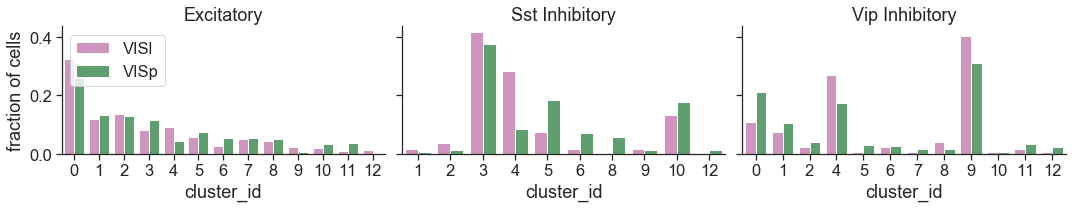

In [288]:
palette = [sns.color_palette()[6],  sns.color_palette()[2]]
areas = ['VISp', 'VISl']
cell_types = np.sort(cluster_df.cell_type.unique())

fig, ax = plt.subplots(1,3, figsize=(15,3), sharey=True)
for i, cell_type in enumerate(cell_types):
    ax[i] = sns.barplot(data=fraction_per_cluster_area[fraction_per_cluster_area.cell_type==cell_type],
                        x='cluster_id', y='fraction', hue='targeted_structure', palette=palette, ax=ax[i])
    ax[i].set_title(cell_type)
    ax[i].get_legend().remove()
    ax[i].set_ylabel('')
ax[0].set_ylabel('fraction of cells')
ax[0].legend(loc='upper left', title='')

fig.tight_layout()

### fraction per depth 

In [293]:
depths = [75, 175, 275, 375]
cluster_ids = np.sort(cluster_df.cluster_id.unique())

In [294]:
total_per_cell_type_and_depth = cluster_df.groupby(['cell_type', 'binned_depth']).count()[['cell_specimen_id']].rename(columns={'cell_specimen_id':'n_total'})
total_per_cell_type_and_depth

n_per_cluster_depth = cluster_df.groupby(['cell_type', 'binned_depth', 'cluster_id']).count()[['cell_specimen_id']].rename(columns={'cell_specimen_id':'n_per_cluster'})
n_per_cluster_depth = n_per_cluster_depth.reset_index()

# make sure each depth and cluster is represented, even if there are none
for depth in depths: 
    for cluster_id in cluster_ids:
        loc_df = n_per_cluster_depth[(n_per_cluster_depth.binned_depth==depth)&(n_per_cluster_depth.cluster_id==cluster_id)]
        ind = len(n_per_cluster_depth)
        if len(loc_df) == 0:
            n_per_cluster_depth.loc[ind+1, :] = [cell_type, depth, cluster_id, 0]
            
fraction_per_cluster_depth= n_per_cluster_depth.merge(total_per_cell_type_and_depth, on=['cell_type', 'binned_depth'])
fraction_per_cluster_depth['fraction'] = fraction_per_cluster_depth.n_per_cluster.values/fraction_per_cluster_depth.n_total.values

fraction_per_cluster_depth['binned_depth'] = [int(depth) for depth in fraction_per_cluster_depth.binned_depth.values]


### Look at coding properties of clusters

#### add cluster IDs to the original dataframe of dropout scores and plot average dropout by session for each cluster

In [295]:
cluster_df

cell_specimen_id  (all-images, Familiar)  (all-images, Novel 1)  \
0            1086587247                0.000000               0.000000   
4            1086618742                0.000000               0.000000   
7            1086503970                0.000000               0.000000   
11           1086618915                0.000000               0.000000   
15           1086524764               -0.023994               0.000000   
...                 ...                     ...                    ...   
18030        1086524450                0.000000              -0.076818   
18033        1086514803                0.000000              -0.013271   
18038        1086514381                0.000000               0.000000   
18042        1086522547                0.000000              -0.127083   
18046        1086539623                0.000000              -0.036515   

       (all-images, Novel >1)  (omissions, Familiar)  (omissions, Novel 1)  \
0                         0.0               0.000000              0.000000   
4                         0.0               0.000000              0.000000   
7                         0.0               0.000000              0.000000   
11                        0.0               0.000000              0.000000   
15                        0.0               0.000000              0.000000   
...                       ...                    ...                   ...   
18030                     0.0               0.000000              0.000000   
18033                     0.0               0.000000              0.000000   
18038                     0.0              -0.099835             -0.022328   
18042                     0.0               0.000000              0.000000   
18046                     0.0               0.000000             -0.043165   

       (omissions, Novel >1)  (behavioral, Familiar)  (behavioral, Novel 1)  \
0                        0.0                0.000000               0.000000   
4                        0.0                0.000000               0.000000   
7                        0.0                0.000000               0.000000   
11                       0.0                0.000000               0.000000   
15                       0.0               -0.459284               0.000000   
...                      ...                     ...                    ...   
18030                    0.0                0.000000              -0.657673   
18033                    0.0                0.000000              -0.902856   
18038                    0.0                0.000000              -0.498194   
18042                    0.0                0.000000              -0.829758   
18046                    0.0                0.000000              -0.664464   

       (behavioral, Novel >1)  ...  binned_depth_x     cell_type_y  \
0                         0.0  ...             275      Excitatory   
4                         0.0  ...             175      Excitatory   
7                         0.0  ...             175      Excitatory   
11                        0.0  ...             175      Excitatory   
15                        0.0  ...             275  Vip Inhibitory   
...                       ...  ...             ...             ...   
18030                     0.0  ...             275      Excitatory   
18033                     0.0  ...             175  Vip Inhibitory   
18038                     0.0  ...             375      Excitatory   
18042                     0.0  ...             275  Vip Inhibitory   
18046                     0.0  ...             375      Excitatory   

       imaging_depth_x  targeted_structure_y binned_depth_y cluster_id  \
0                275.0                  VISp          275.0          0   
4                175.0                  VISp          175.0          0   
7                175.0                  VISp          175.0          0   
11               175.0                  VISp          175.0          0   
15               225.

In [296]:
cluster_ids = pd.DataFrame(index=df_sorted.index, columns=['cluster_id'], data=cluster_id_order)

cluster_rspm = rspm.merge(cluster_ids, on='cell_specimen_id')

In [297]:
cluster_ids

cluster_id
cell_specimen_id            
1086587247                 0
1086618742                 0
1086503970                 0
1086618915                 0
1086524764                 0
...                      ...
1086524450                12
1086514803                12
1086514381                12
1086522547                12
1086539623                12

[4331 rows x 1 columns]

In [128]:
# cluster_rspm['cluster_id'] = [int(cluster_id) for cluster_id in cluster_rspm.cluster_id.values]

for each cluster, look at average dropout for all features, for each session type

#### for 20 clusters

In [129]:
# cluster_ids = np.sort(rspm.cluster_id.unique())
# n_rows = int(len(cluster_ids)/5.)
# fig, ax = plt.subplots(2, 10, figsize=(15,4), sharex=True, sharey=True)
# ax = ax.ravel()
# for i,cluster_id in enumerate(cluster_ids):
#     mean_dropouts_for_cluster = rspm[rspm.cluster_id==cluster_id].groupby('experience_level').mean()[features_to_plot]
#     ax[i] = sns.heatmap(mean_dropouts_for_cluster.T, cmap='RdBu', vmin=-1, vmax=1, ax=ax[i], cbar=False,)#cbar_kws={'shrink':0.7, 'label':model_output_type})
#     ax[i].set_title('cluster_id: '+str(cluster_id))
#     ax[i].set_ylim(-0.5, 4.5)
#     ax[i].set_xlabel('')
# #     ax[i].set_
# fig.tight_layout()

#### 15 clusters

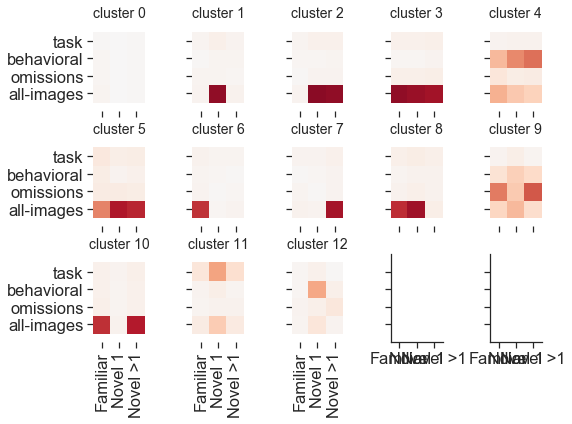

In [299]:
cluster_ids = np.sort(cluster_rspm.cluster_id.unique())

fig, ax = plt.subplots(3, 5, figsize=(8,6), sharex=True, sharey=True)
ax = ax.ravel()
for i,cluster_id in enumerate(cluster_ids):
    mean_dropouts_for_cluster = cluster_rspm[cluster_rspm.cluster_id==cluster_id].groupby('experience_level').mean()[features_to_plot]
    ax[i] = sns.heatmap(mean_dropouts_for_cluster.T, cmap='RdBu', vmin=-1, vmax=1, ax=ax[i], cbar=False,)#cbar_kws={'shrink':0.7, 'label':model_output_type})
    ax[i].set_title('cluster '+str(int(cluster_id)), fontsize=14)
    ax[i].set_ylim(-0.5, 4.5)
    ax[i].set_xlabel('')
#     ax[i].set_
fig.tight_layout()

### plus fraction cells per cluster

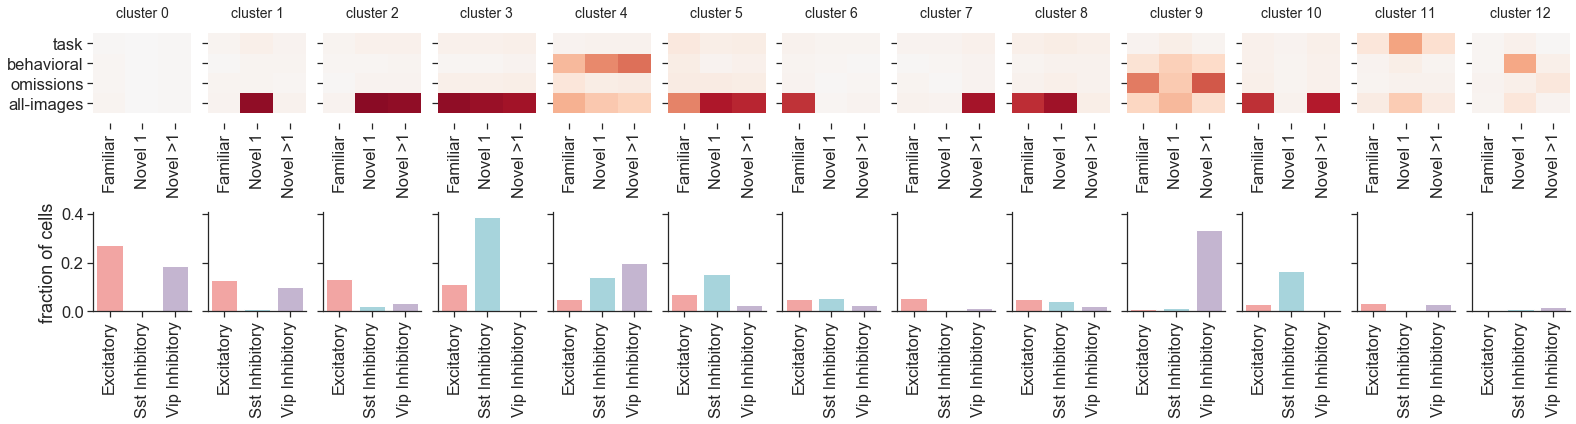

In [302]:
cluster_ids = np.sort(cluster_rspm.cluster_id.unique())
palette = utils.get_cre_line_colors()


fig, ax = plt.subplots(2, 13, figsize=(22,6), sharex='row', sharey='row')
ax = ax.ravel()
for i,cluster_id in enumerate(cluster_ids):
    mean_dropouts_for_cluster = cluster_rspm[cluster_rspm.cluster_id==cluster_id].groupby('experience_level').mean()[features_to_plot]
    ax[i] = sns.heatmap(mean_dropouts_for_cluster.T, cmap='RdBu', vmin=-1, vmax=1, ax=ax[i], cbar=False,)#cbar_kws={'shrink':0.7, 'label':model_output_type})
    ax[i].set_title('cluster '+str(int(cluster_id)), fontsize=14)
    ax[i].set_ylim(-0.5, 4.5)
    ax[i].set_xlabel('')
    fraction = np.round(fraction_per_cluster[fraction_per_cluster.cluster_id==cluster_id].fraction.values[0]*100,1)
    n_cells = int(len(cluster_rspm[cluster_rspm.cluster_id==cluster_id].cell_specimen_id.unique()))
    ax[i].set_title('cluster '+str(int(cluster_id))+'\n'+str(fraction)+'%, n='+str(n_cells), fontsize=16)
    
    
    data = fraction_per_cluster[fraction_per_cluster.cluster_id==cluster_id]
    ax[i+len(cluster_ids)] = sns.barplot(data=data, 
                                        x='cell_type', y='fraction', #hue='cell_type', 
                                         order=cell_types, #hue_order=cell_types,
                                         palette=palette, ax=ax[i+len(cluster_ids)])
    ax[i+len(cluster_ids)].set_ylabel('fraction of cells')
    ax[i+len(cluster_ids)].set_xlabel('')
#     ax[i+len(cluster_ids)].get_legend().remove()
    ax[i+len(cluster_ids)].set_xticklabels(cell_types, rotation=90)
    
    if i != 0:
        ax[i+len(cluster_ids)].set_ylabel('')
    
    
#     ax[i].set_
fig.tight_layout()

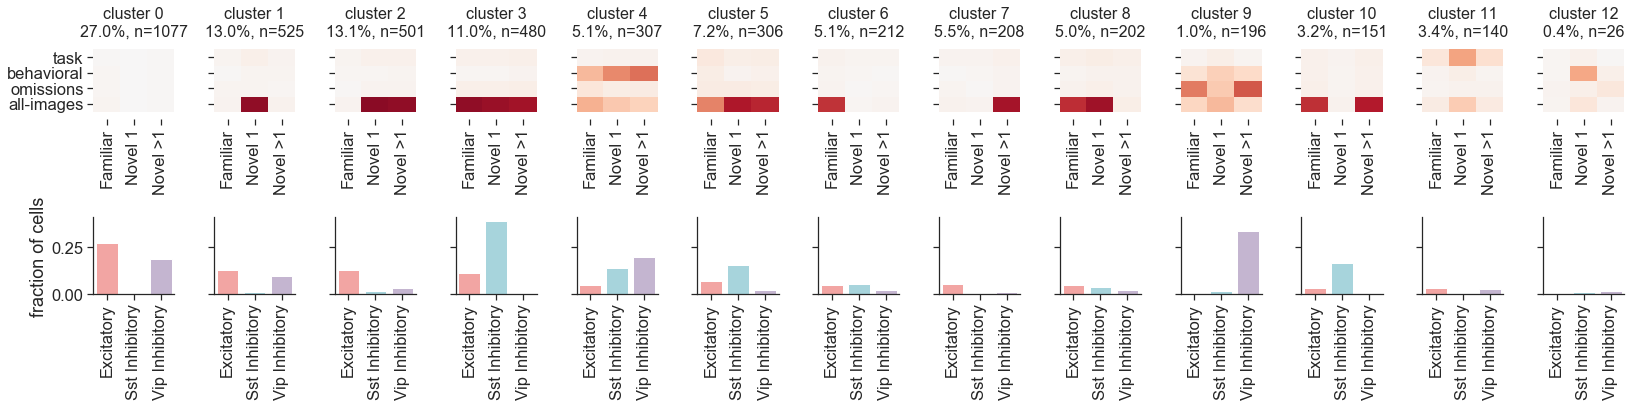

In [307]:
cluster_ids = np.sort(cluster_rspm.cluster_id.unique())
palette = utils.get_cre_line_colors()


fig, ax = plt.subplots(2, 13, figsize=(23,6), sharex='row', sharey='row')
ax = ax.ravel()
for i,cluster_id in enumerate(cluster_ids):
    mean_dropouts_for_cluster = cluster_rspm[cluster_rspm.cluster_id==cluster_id].groupby('experience_level').mean()[features_to_plot]
    ax[i] = sns.heatmap(mean_dropouts_for_cluster.T, cmap='RdBu', vmin=-1, vmax=1, ax=ax[i], cbar=False,)#cbar_kws={'shrink':0.7, 'label':model_output_type})
    ax[i].set_title('cluster '+str(int(cluster_id)), fontsize=14)
    ax[i].set_ylim(-0.5, 4.5)
    ax[i].set_xlabel('')
    fraction = np.round(fraction_per_cluster[fraction_per_cluster.cluster_id==cluster_id].fraction.values[0]*100,1)
    n_cells = int(len(cluster_rspm[cluster_rspm.cluster_id==cluster_id].cell_specimen_id.unique()))
    ax[i].set_title('cluster '+str(int(cluster_id))+'\n'+str(fraction)+'%, n='+str(n_cells), fontsize=16)
    
    
    data = fraction_per_cluster[fraction_per_cluster.cluster_id==cluster_id]
    ax[i+len(cluster_ids)] = sns.barplot(data=data, 
                                        x='cell_type', y='fraction', #hue='cell_type', 
                                         order=cell_types, #hue_order=cell_types,
                                         palette=palette, ax=ax[i+len(cluster_ids)])
    ax[i+len(cluster_ids)].set_ylabel('fraction of cells')
    ax[i+len(cluster_ids)].set_xlabel('')
#     ax[i+len(cluster_ids)].get_legend().remove()
    ax[i+len(cluster_ids)].set_xticklabels(cell_types, rotation=90)
    
    if i != 0:
        ax[i+len(cluster_ids)].set_ylabel('')
    
    
#     ax[i].set_
fig.tight_layout()

### plot clusters with fractions and pop avgs. 

In [303]:
import visual_behavior.visualization.ophys.platform_paper_figures as ppf
from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorOphysProjectCache
cache_dir = loading.get_platform_analysis_cache_dir()
cache = VisualBehaviorOphysProjectCache.from_s3_cache(cache_dir=cache_dir)

In [304]:
%%time

cache_dir = loading.get_platform_analysis_cache_dir()
cache = VisualBehaviorOphysProjectCache.from_s3_cache(cache_dir)

# set various params
df_name = 'omission_response_df'
conditions = ['cell_specimen_id']
use_events = True
filter_events = True

# load multi_session_df
multi_session_df = loading.get_multi_session_df(cache_dir, df_name, conditions, experiments_table, 
                                                use_events=use_events, filter_events=filter_events)
print(len(multi_session_df.ophys_experiment_id.unique()))

original_multi_session_df = multi_session_df.copy()

# limit to platform paper dataset
multi_session_df = multi_session_df[multi_session_df.ophys_experiment_id.isin(experiments_table.index.values)]
print(len(multi_session_df.ophys_experiment_id.unique()))

# merge with metadata
multi_session_df = multi_session_df.merge(experiments_table, on='ophys_experiment_id')
print(len(multi_session_df.ophys_experiment_id.unique()))

multi_session_df = multi_session_df.reset_index(drop=True)

1941
1249
1249
Wall time: 18.1 s


#### set params

In [308]:
cluster_mdf = multi_session_df.merge(cluster_df[['cell_specimen_id', 'cluster_id']], on='cell_specimen_id')

# filter
project_code = 'VisualBehaviorMultiscope'
# get timestamps 
multiscope_expt = experiments_table[experiments_table.project_code==project_code].index.values[0] 
timestamps = ppf.get_timestamps_for_response_df_type(cache, multiscope_expt, df_name)
print(len(timestamps))

axes_column = 'cluster_id'
hue_column = 'experience_level'
hue_conditions = np.sort(cluster_mdf[hue_column].unique())
palette = utilities.get_experience_level_colors()
xlim_seconds = [-1,1.5]
change = False
omitted = True
xlabel = 'time (sec)'

sdf = cluster_mdf[cluster_mdf.project_code==project_code].copy()

# remove traces with incorrect length - why does this happen?
sdf = sdf.reset_index(drop=True)
indices = [index for index in sdf.index if len(sdf.iloc[index].mean_trace) == 107]
sdf = sdf.loc[indices]
print(len(sdf.mean_trace.values[0]))


C:\Users\marinag\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


107
107
107


### plot

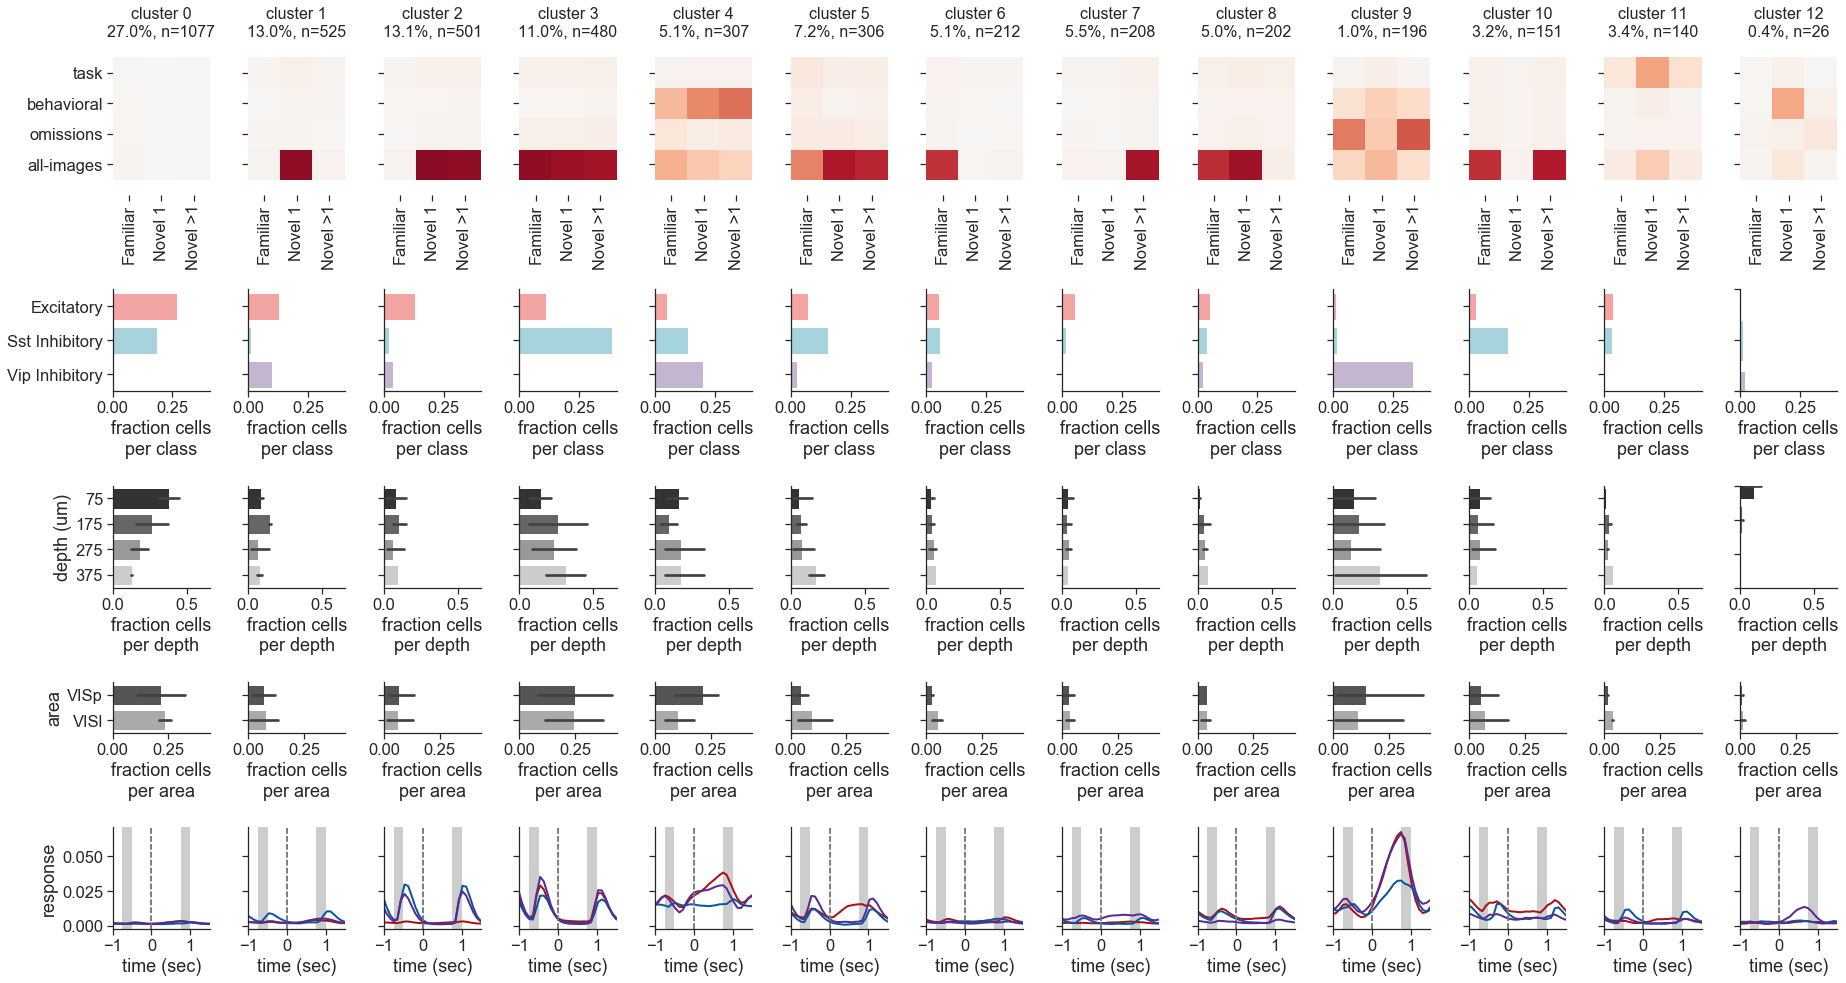

In [309]:
depths = [75, 175, 275, 375]
areas = ['VISp', 'VISl']
# cluster_ids = np.sort(cluster_rspm.cluster_id.unique())
# cluster_ids = cluster_order.copy()
# cluster_ids = fraction_per_cluster.cluster_id.values[np.argsort(fraction_per_cluster.fraction.values)]
cluster_ids = np.sort(cluster_rspm.cluster_id.unique())
# vip_cluster_order = [9, 0, 1, 2, 3, 8, 4, 6, 5, 7]
# cluster_ids = vip_cluster_order
palette = utils.get_experience_level_colors()

n_clusters = len(cluster_ids)

fig, ax = plt.subplots(5, n_clusters, figsize=(n_clusters*2, 14), sharex='row', sharey='row', gridspec_kw={'height_ratios': [3, 2, 2, 1, 2]})
ax = ax.ravel()
for i,cluster_id in enumerate(cluster_ids):
    mean_dropouts_for_cluster = cluster_rspm[cluster_rspm.cluster_id==cluster_id].groupby('experience_level').mean()[features_to_plot]
    ax[i] = sns.heatmap(mean_dropouts_for_cluster.T, cmap='RdBu', vmin=-1, vmax=1, ax=ax[i], cbar=False,)#cbar_kws={'shrink':0.7, 'label':model_output_type})
    fraction = np.round(fraction_per_cluster[fraction_per_cluster.cluster_id==cluster_id].fraction.values[0]*100,1)
    n_cells = int(len(cluster_rspm[cluster_rspm.cluster_id==cluster_id].cell_specimen_id.unique()))
    ax[i].set_title('cluster '+str(int(cluster_id))+'\n'+str(fraction)+'%, n='+str(n_cells), fontsize=16)
    ax[i].set_yticklabels(mean_dropouts_for_cluster.keys(), rotation=0)
    ax[i].set_ylim(-0.5, 4.5)
    ax[i].set_xlabel('')
    
    palette = utils.get_cre_line_colors()
    data = fraction_per_cluster[fraction_per_cluster.cluster_id==cluster_id]
    ax[i+len(cluster_ids)] = sns.barplot(data=data, orient='h', 
                                        y='cell_type', x='fraction', #hue='cell_type', 
#                                          order=depths, #hue_order=cell_types,
                                         palette=palette, ax=ax[i+len(cluster_ids)])
    ax[i+len(cluster_ids)].set_ylabel('')
    ax[i+len(cluster_ids)].set_xlabel('fraction cells\nper class')
    ax[i+len(cluster_ids)].set_yticks(np.arange(0, len(cell_types)))
    ax[i+len(cluster_ids)].set_yticklabels(cell_types, rotation=0)
    
    
    data = fraction_per_cluster_depth[fraction_per_cluster_depth.cluster_id==cluster_id]
    ax[i+(len(cluster_ids)*2)] = sns.barplot(data=data, orient='h', 
                                        y='binned_depth', x='fraction', #hue='cell_type', 
#                                          order=depths, #hue_order=cell_types,
                                         palette='gray', ax=ax[i+(len(cluster_ids)*2)])
    ax[i+(len(cluster_ids)*2)].set_ylabel('depth (um)')
    ax[i+(len(cluster_ids)*2)].set_xlabel('fraction cells\nper depth')
    ax[i+(len(cluster_ids)*2)].set_yticks(np.arange(0, len(depths)))
    ax[i+(len(cluster_ids)*2)].set_yticklabels(depths, rotation=0)
    
    data = fraction_per_cluster_area[fraction_per_cluster_area.cluster_id==cluster_id]
    ax[i+(len(cluster_ids)*3)] = sns.barplot(data=data, orient='h', 
                                        y='targeted_structure', x='fraction', #hue='cell_type', 
#                                          order=depths, #hue_order=cell_types,
                                         palette='gray', ax=ax[i+(len(cluster_ids)*3)])
    ax[i+(len(cluster_ids)*3)].set_ylabel('area')
    ax[i+(len(cluster_ids)*3)].set_xlabel('fraction cells\nper area')
    ax[i+(len(cluster_ids)*3)].set_yticklabels(areas, rotation=0)
    
    # plot mean traces
    palette = utils.get_experience_level_colors()
    for c, hue in enumerate(hue_conditions):

        traces = sdf[(sdf['cluster_id'] == cluster_id) & (sdf[hue_column] == hue)].mean_trace.values
        ax[i+(len(cluster_ids)*4)] = utils.plot_mean_trace(np.asarray(traces), timestamps, ylabel='response',
                                      legend_label=hue, color=palette[c], interval_sec=1, plot_sem=False,
                                      xlim_seconds=xlim_seconds, ax=ax[i+(len(cluster_ids)*4)])
        ax[i+(len(cluster_ids)*4)] = utils.plot_flashes_on_trace(ax[i+(len(cluster_ids)*4)], timestamps, change=change, omitted=omitted)
        ax[i+(len(cluster_ids)*4)].axvline(x=0, ymin=0, ymax=1, linestyle='--', color='gray')
        ax[i+(len(cluster_ids)*4)].set_title('')
        ax[i+(len(cluster_ids)*4)].set_xlim(xlim_seconds)
        ax[i+(len(cluster_ids)*4)].set_xlabel(xlabel)
            
    if i != 0:
        ax[i+len(cluster_ids)].set_ylabel('')
        ax[i+(len(cluster_ids)*2)].set_ylabel('')
        ax[i+(len(cluster_ids)*3)].set_ylabel('') 
        ax[i+(len(cluster_ids)*4)].set_ylabel('') 
    
#     ax[i].set_
fig.tight_layout()
# plt.suptitle(cell_type, x=0.53, y=1.03, fontsize=20)